# Data Structuring and Pruning

In [1]:
# Load datasets

import json
import pathlib
import importlib
from collections import defaultdict, Counter
import pyupset as pyu
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import re
from matplotlib.gridspec import GridSpec
import csv
import requests
import pickle
import os


from vicckb import model as viccdb
from vicckb.definitions import DATA_ROOT, PROJECT_ROOT
%matplotlib inline

REPOPATH = PROJECT_ROOT.parent
OUTPATH = REPOPATH / 'out'
FIGPATH = OUTPATH / 'figures'

os.makedirs(FIGPATH, exist_ok=True)

In [2]:
# reload module and load data
importlib.reload(viccdb)
vdb = viccdb.ViccDb()
vdb.report_groups()

cgi: 1073 (6.3% of total)
civic: 3340 (19.8% of total)
jax: 5754 (34.0% of total)
molecularmatch: 2085 (12.3% of total)
oncokb: 4048 (24.0% of total)
pmkb: 600 (3.6% of total)
16900 total associations


In [3]:
# for now, omit brca from analysis
brca = vdb.select(lambda x: x['source'] == 'brca')
core_vdb = vdb - brca
core_vdb.report_groups()

cgi: 1073 (6.3% of total)
civic: 3340 (19.8% of total)
jax: 5754 (34.0% of total)
molecularmatch: 2085 (12.3% of total)
oncokb: 4048 (24.0% of total)
pmkb: 600 (3.6% of total)
16900 total associations


In [4]:
# remove biological associations
oncokb_biological = core_vdb.select(lambda x: x['source'] == 'oncokb' and 'biological' in x['raw'])
oncokb_biological.report_groups(core_vdb)
core_vdb = core_vdb - oncokb_biological

oncokb: 3801 (93.9% of superset)
Total: 3801 (22.5% of superset)


## Evidence Uniqueness

This section deals with non-unique entries from the database. This is a temporary measure until the importers are fixed. As such, it uses private variables and non-standard methods to hack around the built-in uniqueness assumptions that are violated by these data. Remove this entire section once the source hash checks pass.

In [5]:
core_vdb.report_groups()

cgi: 1073 (8.2% of total)
civic: 3340 (25.5% of total)
jax: 5754 (43.9% of total)
molecularmatch: 2085 (15.9% of total)
oncokb: 247 (1.9% of total)
pmkb: 600 (4.6% of total)
13099 total associations


In [6]:
# Non-unique raw entries
raw_duplicates = core_vdb.select(lambda x: len(core_vdb._hashed[hash(x)]) > 1)
raw_duplicates.report_groups(core_vdb)

cgi: 2 (0.2% of superset)
pmkb: 311 (51.8% of superset)
Total: 313 (2.4% of superset)


In [7]:
cgi_dups = raw_duplicates.by_source('cgi')
cgi_clean = [x for x in cgi_dups if x['raw']['Drug status']]
test = viccdb.ViccDb([x for x in core_vdb if x not in cgi_dups] + list(cgi_clean))
test.report_groups(core_vdb)

cgi: 1072 (99.9% of superset)
civic: 3340 (100.0% of superset)
jax: 5754 (100.0% of superset)
molecularmatch: 2085 (100.0% of superset)
oncokb: 247 (100.0% of superset)
pmkb: 600 (100.0% of superset)
Total: 13098 (100.0% of superset)


In [8]:
# Test matches expectation, moving to core
core_vdb = test

In [9]:
pmkb_dups = raw_duplicates.by_source('pmkb')

In [10]:
len(pmkb_dups._hashed)

82

In [11]:
len(pmkb_dups)

311

In [12]:
merged_associations = list()
for hash_key, equivalent_associations in pmkb_dups._hashed.items():
    root_association = equivalent_associations.pop()
    for other_association in equivalent_associations:
        root_association['features'].append(other_association['features'][0])
    merged_associations.append(root_association)

In [13]:
test = viccdb.ViccDb([x for x in core_vdb if x not in merged_associations] + list(merged_associations))
test.report_groups(core_vdb)

cgi: 1072 (100.0% of superset)
civic: 3340 (100.0% of superset)
jax: 5754 (100.0% of superset)
molecularmatch: 2085 (100.0% of superset)
oncokb: 247 (100.0% of superset)
pmkb: 371 (61.8% of superset)
Total: 12869 (98.3% of superset)


In [14]:
x = len(core_vdb.by_source('pmkb')) - len(pmkb_dups) + len(pmkb_dups._hashed)
print("Expecting {} associations for PMKB".format(x))

Expecting 371 associations for PMKB


In [15]:
# Test matches expectation, moving to core
core_vdb = test

## Evidence filtering

Removal of all evidence without associated publications, followed by removal of all associations without evidence.

In [16]:
def clean_refs(association):
    evidences = association['association']['evidence']
    evidence_indices_to_delete = list()
    for i, evidence in enumerate(evidences):
        assert isinstance(publications, list)
        publications = [x for x in evidence['info']['publications'] if x]
        evidence['info']['publications'] = publications
        if not publications:
            evidence_indices_to_delete.append(i)
    for index in sorted(evidence_indices_to_delete, reverse=True):
        del association['association']['evidence'][index]

map(clean_refs, core_vdb)
core_missing_ref = core_vdb.select(lambda x: not any(x.publications))
core_missing_ref.report_groups(core_vdb)
core_vdb = core_vdb - core_missing_ref

jax: 8 (0.1% of superset)
molecularmatch: 5 (0.2% of superset)
Total: 13 (0.1% of superset)


In [17]:
core_vdb.report_groups()

cgi: 1072 (8.3% of total)
civic: 3340 (26.0% of total)
jax: 5746 (44.7% of total)
molecularmatch: 2080 (16.2% of total)
oncokb: 247 (1.9% of total)
pmkb: 371 (2.9% of total)
12856 total associations


In [18]:
# All associations should have an evidence level

core_vdb.select(lambda x: not x.evidence_level).report_groups(core_vdb)

Total: 0 (0.0% of superset)


## Feature coordinates

What follows is a detailed look at associations without start and end coordinates after normalization, and a set of regular expression filters to separate out these associations into chunks that can be annotated with gene- or exon-level coordinates, as appropriate.

In [19]:
# Associations with more than 1 feature
x = core_vdb.select(lambda x: len(x.features) > 1)
x.report_groups(vdb)

cgi: 373 (34.8% of superset)
jax: 1789 (31.1% of superset)
molecularmatch: 17 (0.8% of superset)
oncokb: 35 (0.9% of superset)
Total: 2214 (13.1% of superset)


In [20]:
# Associations without at least 1 complete and valid feature
no_features = core_vdb.select(lambda x: len(x.features) == 0)
no_features.report_groups(vdb)

cgi: 9 (0.8% of superset)
civic: 17 (0.5% of superset)
jax: 10 (0.2% of superset)
molecularmatch: 17 (0.8% of superset)
oncokb: 2 (0.0% of superset)
pmkb: 2 (0.3% of superset)
Total: 57 (0.3% of superset)


In [21]:
vdb[0]['association']['phenotype']

{'type': {'source': 'http://purl.obolibrary.org/obo/doid',
  'term': 'lung adenocarcinoma',
  'id': 'DOID:3910'},
 'description': 'lung adenocarcinoma',
 'family': 'lung cancer'}

In [22]:
# Associations with coordinate features
coord_featured = core_vdb - no_features
coord_featured.report_groups(core_vdb)

cgi: 1063 (99.2% of superset)
civic: 3323 (99.5% of superset)
jax: 5736 (99.8% of superset)
molecularmatch: 2063 (99.2% of superset)
oncokb: 245 (99.2% of superset)
pmkb: 369 (99.5% of superset)
Total: 12799 (99.6% of superset)


## Fix PMKB features

In [23]:
with open('vicckb/data/gene_strand.pkl', 'rb') as f:
    gene_strand = pickle.load(f)

In [24]:
COMPLEMENT = {
    'A': 'T',
    'T': 'A',
    'G': 'C',
    'C': 'G',
    '-': '-'
}

complement_map = str.maketrans(COMPLEMENT)

def get_gene_strand(gene, trx_id):
    strand = gene_strand.get((gene, trx_id), None)
    if strand is None:
        cmd = '''wget -q -O - 'http://grch37.ensembl.org/biomart/martservice?query=<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE Query>
<Query  virtualSchemaName = "default" formatter = "CSV" header = "0" uniqueRows = "0" count = "" datasetConfigVersion = "0.6" >
<Dataset name = "hsapiens_gene_ensembl" interface = "default" >
<Filter name = "hgnc_symbol" value = "{}"/>
<Attribute name = "ensembl_transcript_id" />
<Attribute name = "strand" />
</Dataset>
</Query>' | grep '{}'
'''.format(gene, trx_id)
        result = !{cmd}
        strand = result[0].split(',')[-1]
        gene_strand[(gene, trx_id)] = strand
        return strand
    return strand

for association in core_vdb.by_source('pmkb'):
    del(association._features)
    for feature in association['features']:
        gene = feature['geneSymbol']
        trx_id = feature['attributes']['transcript']['string_value']
        strand = get_gene_strand(gene, trx_id)
        if strand == '-1':
            # feature['ref'] = feature['ref'][::-1].translate(complement_map)
            try:
                feature['alt'] = feature['alt'][::-1].translate(complement_map)
            except KeyError:
                continue


In [25]:
with open('vicckb/data/gene_strand.pkl', 'wb') as f:
    pickle.dump(gene_strand, f)

### Remainder of section is inactivated code for identifying associations without coordinates

import re

def feature_filter(re_obj, associations):
    # report matches and return non-matches
    found = list(filter(lambda x: re_obj.search(x['feature_names']) is not None, associations))
    not_found = list(filter(lambda x: re_obj.search(x['feature_names']) is None, associations))
    report_groups(found)
    return(not_found)

amp_re = re.compile(r'(amplification)|(loss)|(amp)', re.IGNORECASE)
remainder = feature_filter(amp_re, no_partial_coord_featured_with_feature_names)

fusion_re = re.compile(r'(\w{2,}-\w{2,})|(fusion)', re.IGNORECASE)
r2 = feature_filter(fusion_re, remainder)

ppm_re = re.compile(r'\w+(:| )[a-z]\d+[a-z]?(fs\*?)?$', re.IGNORECASE)
r3 = feature_filter(ppm_re, r2)

indel_re = re.compile(r'\w+(:| )\w+(ins\w+)|(del($|ins\w+))|(dup$)')
r4 = feature_filter(indel_re, r3)

bucket_re = re.compile(r'[A-Z0-9]+( (in)?act)?( oncogenic)? mut((ant)|(ation))?$')
r5 = feature_filter(bucket_re, r4)

exon_re = re.compile(r'exon', re.IGNORECASE)
r6 = feature_filter(exon_re, r5)

expression_re = re.compile(r'(exp)|(^\w+ (pos(itive)?)|(neg(ative)?)|(biallelic inactivation)$)|(truncating)|(deletion)', re.IGNORECASE)
r7 = feature_filter(expression_re, r6)

report_groups(r7)

get_feature_names([x for x in r7 if x['source'] == 'cgi'])

## Diseases

In [26]:
disease_missing = core_vdb.select(lambda x: x.disease is None)
disease_missing.report_groups(core_vdb)

civic: 1 (0.0% of superset)
Total: 1 (0.0% of superset)


In [27]:
disease_missing[0]['association']

{'description': 'Pericytoma with t(7;12) is a soft tissue tumor characterized by fusion of the ACTB and GLI genes through the translocation t(7;12)(p22;q13). In this study the genomic breakpoints of 5 cases were characterized.',
 'publication_url': ['http://www.ncbi.nlm.nih.gov/pubmed/15555571'],
 'source_link': 'https://civic.genome.wustl.edu/events/genes/2279/summary/variants/780/summary',
 'evidence': [{'info': {'publications': ['http://www.ncbi.nlm.nih.gov/pubmed/15555571']},
   'evidenceType': {'sourceName': 'CIVIC', 'id': '1844'},
   'description': 'Positive'}],
 'environmentalContexts': [],
 'evidence_label': 'B',
 'phenotype': {'description': 'Pericytoma',
  'family': 'Uncategorized-PHN',
  'id': 'http://www.disease-ontology.org/'},
 'evidence_level': 2,
 'response_type': 'Positive'}

In [28]:
# Fix DOID

for association in core_vdb.select(lambda x: x.disease and x.disease.name == 'CNS Cancer'):
    association['association']['phenotype']['type']['term'] = 'central nervous system cancer'
    association['association']['phenotype']['type']['id'] = 'DOID:3620'

In [29]:
mismatched_do_cgi = core_vdb.select(lambda x: x.disease and \
                                x.disease.source.lower().endswith('doid') and \
                                not x.disease.id.startswith('DOID') and \
                                x.source == 'cgi'
                               )
mismatched_do_cgi.report_groups(core_vdb)

cgi: 108 (10.1% of superset)
Total: 108 (0.8% of superset)


In [30]:
mismatched_do_cgi[0]['association']['phenotype']

{'type': {'source': 'http://purl.obolibrary.org/obo/doid',
  'term': 'stomach',
  'id': 'UBERON:0000945'},
 'description': 'stomach',
 'family': 'food storage organ'}

In [31]:
mismatched_do_cgi[0]['raw']

{'Targeting': '',
 'Source': 'PMID:22614881;PMID:22290393',
 'cDNA': [''],
 'Primary Tumor type': 'Stomach',
 'individual_mutation': [''],
 'Drug full name': 'EGFR mAb inhibitors',
 'Curator': 'RDientsmann',
 'Drug family': '[EGFR mAb inhibitor]',
 'Alteration': 'KRAS:.',
 'Drug': '[]',
 'Biomarker': 'KRAS oncogenic mutation',
 'gDNA': [''],
 'Drug status': '',
 'Gene': 'KRAS',
 'transcript': [''],
 'strand': [''],
 'info': [''],
 'Assay type': '',
 'Alteration type': 'MUT',
 'region': [''],
 'Evidence level': 'Pre-clinical',
 'Association': 'Resistant',
 'Metastatic Tumor Type': ''}

In [32]:
from vicckb.definitions import DATA_ROOT
from vicckb.harmonizers import DiseaseHarmonizer
adh = DiseaseHarmonizer(map_file=(DATA_ROOT / 'disease_alias.tsv'),
                             disease_ontology='DOID')

In [33]:
disease = mismatched_do_cgi[0]['raw']['Primary Tumor type']
adh.harmonize(disease)

{'id': 'DOID:10534',
 'ontology': 'DOID',
 'term': 'stomach cancer',
 'resultEngine': 'ebi'}

In [34]:
for cgi_association in mismatched_do_cgi:
    disease = cgi_association['raw']['Primary Tumor type']
    harmonized = adh.harmonize(disease)
    cgi_association['association']['phenotype'] = {
        'description': disease,
        'type': {
            'id': harmonized['id'],
            'source': harmonized['ontology'],
            'term': harmonized['term']
        }
    }

In [35]:
mismatched_do_cgi = core_vdb.select(lambda x: x.disease and \
                                x.disease.source.lower().endswith('doid') and \
                                not x.disease.id.startswith('DOID') and \
                                x.source == 'cgi'
                               )
mismatched_do_cgi.report_groups(core_vdb)

Total: 0 (0.0% of superset)


In [36]:
core_vdb.select(lambda x: not x.disease and x.source == 'cgi').report_groups()

0 total associations


In [37]:
other_do_cgi = core_vdb.select(lambda x: x.disease and \
                x.source == 'cgi' and \
                not x.disease.source.lower().endswith('doid'))
other_do_cgi.report_groups()

cgi: 101 (100.0% of total)
101 total associations


In [38]:
for cgi_association in other_do_cgi:
    disease = cgi_association['raw']['Primary Tumor type']
    harmonized = adh.harmonize(disease)
    cgi_association['association']['phenotype'] = {
        'description': disease,
        'type': {
            'id': harmonized['id'],
            'source': harmonized['ontology'],
            'term': harmonized['term']
        }
    }

In [39]:
core_vdb.select(lambda x: x.disease and \
                x.source == 'cgi' and \
                not x.disease.source.lower().endswith('doid')).report_groups()

0 total associations


## Drugs

In [40]:
drugs_missing = core_vdb.select(lambda x: len(x.drugs) == 0)
drugs_missing.report_groups(core_vdb)

cgi: 112 (10.4% of superset)
civic: 1261 (37.8% of superset)
jax: 457 (8.0% of superset)
molecularmatch: 120 (5.8% of superset)
oncokb: 8 (3.2% of superset)
pmkb: 371 (100.0% of superset)
Total: 2329 (18.1% of superset)


## Genes

In [41]:
ambiguous = list()
for a in core_vdb:
    a.genes

# assert len(ambiguous) == 0  # Ensure there are no ambiguous genes from knowledgebases

/Users/awagner/Workspace/git/vicckb/vicckb/model.py:257: UserWarning: Ambiguous gene symbol MLL2 in assertion 235677252030682
  warn('Ambiguous gene symbol {} in assertion {}'.format(g, self))


## Cache

Saving core_vdb to cache for testing.

In [42]:
core_vdb.cache_data()

# Knowledgebase Comparison

## Publications

### All publications

/Users/awagner/anaconda/envs/test/lib/python3.7/site-packages/pyupset/visualisation.py:571: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  final_df = self.df_dict[seed].set_index(pd.Index(self.df_dict[seed][self.unique_keys])).ix[


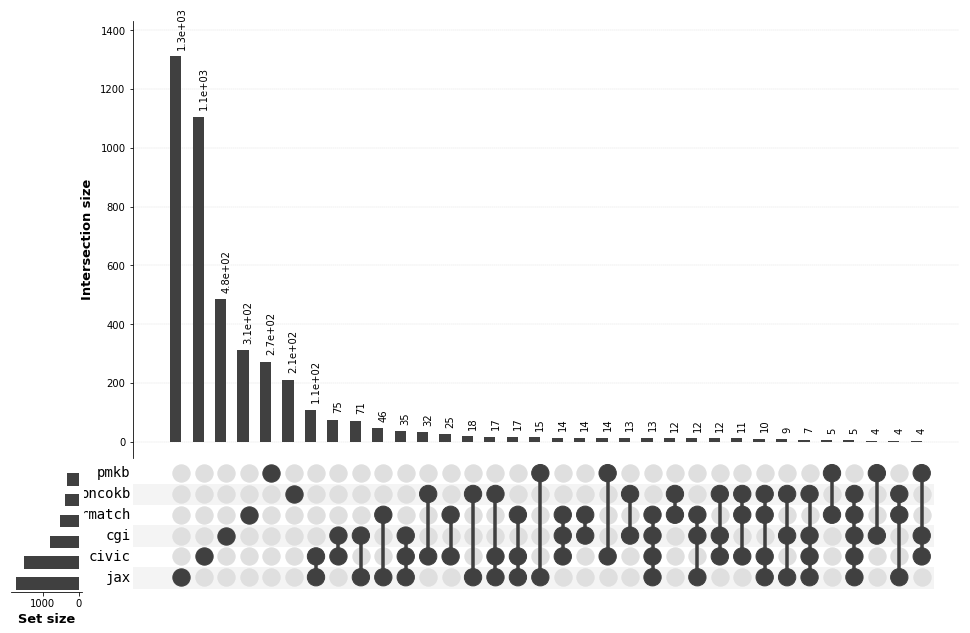

In [43]:
x = core_vdb.plot_element_by_source('publications', min_bound=4)
f = x['figure']
# f.savefig('out/publications.pdf')
# x['input_data']

In [44]:
## For Sidi

ebs = x['input_data']
df_dict = dict()
for source in ebs:
    fe = list(filter(lambda x: bool(x), ebs[source]))
    df_dict[source] = pd.DataFrame(fe, columns=['attribute'])


In [45]:
with open('example.pkl', 'wb') as f:
    pickle.dump(df_dict, f)

In [46]:
with open('example.pkl', 'rb') as f:
    df_dict = pickle.load(f)

In [47]:
!open .

In [48]:
# Publications uniquely cited
data = x['input_data']
total = 0
for source in data:
    publications_from_elsewhere = set()
    for source2 in data:
        if source == source2:
            continue
        publications_from_elsewhere.update(data[source2])
    unique = data[source] - publications_from_elsewhere
    print("{}: {} resource-specific publications".format(source, len(unique)))
    total += len(unique)
print("{} ({:.2%}) total resource-specific publications".format(total, total / len(set.union(*(data.values())))))

molecularmatch: 312 resource-specific publications
civic: 1106 resource-specific publications
pmkb: 272 resource-specific publications
oncokb: 211 resource-specific publications
jax: 1311 resource-specific publications
cgi: 484 resource-specific publications
3696 (84.89%) total resource-specific publications


In [49]:
p_sets = core_vdb.get_element_by_source('publications')

len((p_sets['civic'] & p_sets['jax']) - p_sets['pmkb'] - p_sets['oncokb'] - p_sets['molecularmatch'] - p_sets['cgi'])

109

In [50]:
x = core_vdb.element_by_source_stats('publications')
x['ubiquitous'] # Bose et al. Cancer Discovery 2013

3696 / 4354 (84.89%) of publications are represented in only 1 resource.
203 / 4354 (4.66%) of publications are represented in the majority of (3) resources.
1 / 4354 (0.02%) of publications are represented across all resources.


{<class 'vicckb.model.Publication'>: 23220880}

### PMIDs

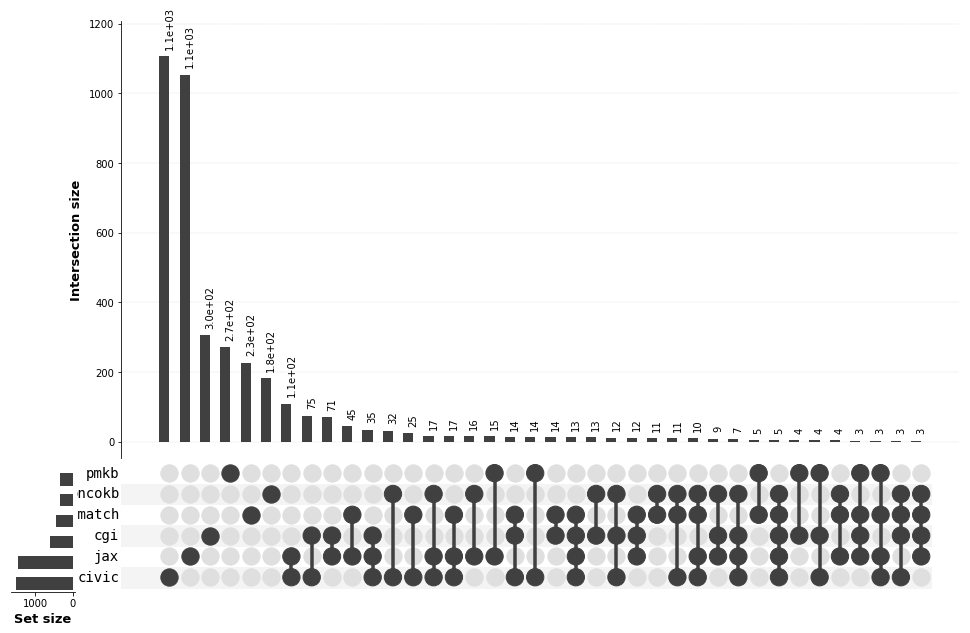

In [51]:
x = core_vdb.plot_element_by_source('publications', lambda x: x.pmid, min_bound=3)
# f = x['figure']
# f.savefig('out/pmids.pdf')

In [52]:
x = core_vdb.element_by_source_stats('publications', lambda x: x.pmid)
x['ubiquitous'] # Bose et al. Cancer Discovery 2013

3146 / 3800 (82.79%) of publications are represented in only 1 resource.
203 / 3800 (5.34%) of publications are represented in the majority of (3) resources.
1 / 3800 (0.03%) of publications are represented across all resources.


{<class 'vicckb.model.Publication'>: 23220880}

## Genes

In [53]:
g_set = core_vdb.get_element_by_source('genes')
x = g_set['civic']
for n, s in g_set.items():
    if n == 'civic':
        continue
    x = x - s
len(x)

144

In [54]:
no_genes = core_vdb.select(lambda x: not x.genes)
no_genes.report_groups(core_vdb)

cgi: 1 (0.1% of superset)
molecularmatch: 5 (0.2% of superset)
oncokb: 2 (0.8% of superset)
Total: 8 (0.1% of superset)


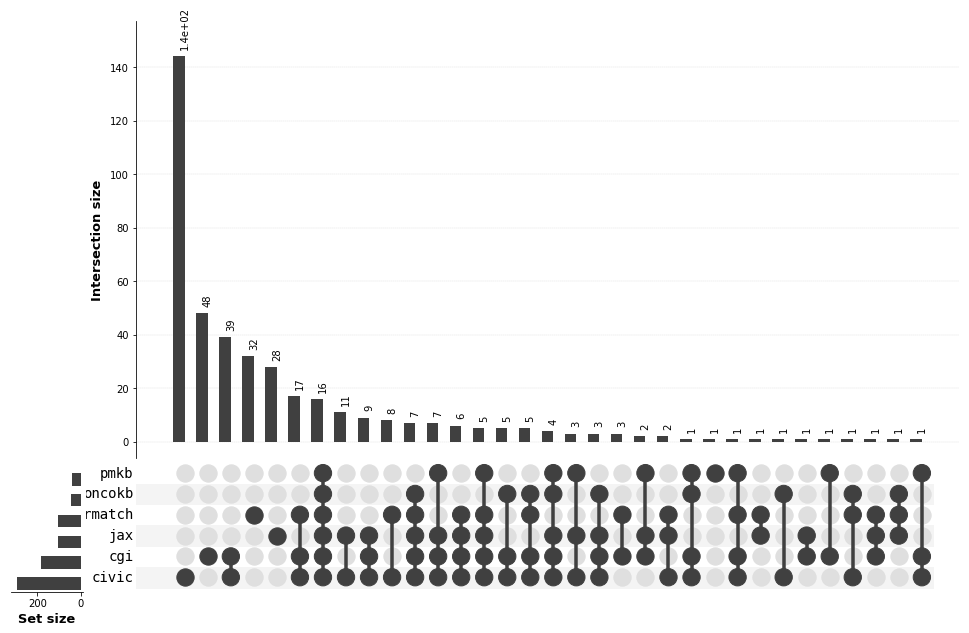

In [55]:
with_genes = core_vdb - no_genes
x = with_genes.plot_element_by_source('genes')
# f = x['figure']
# f.savefig('out/genes.pdf')

In [56]:
x = with_genes.element_by_source_stats('genes')
x['ubiquitous']

253 / 415 (60.96%) of genes are represented in only 1 resource.
97 / 415 (23.37%) of genes are represented in the majority of (3) resources.
16 / 415 (3.86%) of genes are represented across all resources.


{<class 'vicckb.model.Gene'>: EGFR,
 <class 'vicckb.model.Gene'>: ERBB2,
 <class 'vicckb.model.Gene'>: FGFR3,
 <class 'vicckb.model.Gene'>: FGFR2,
 <class 'vicckb.model.Gene'>: FLT3,
 <class 'vicckb.model.Gene'>: ALK,
 <class 'vicckb.model.Gene'>: ABL1,
 <class 'vicckb.model.Gene'>: KIT,
 <class 'vicckb.model.Gene'>: KRAS,
 <class 'vicckb.model.Gene'>: MET,
 <class 'vicckb.model.Gene'>: NOTCH1,
 <class 'vicckb.model.Gene'>: NRAS,
 <class 'vicckb.model.Gene'>: PDGFRA,
 <class 'vicckb.model.Gene'>: PIK3CA,
 <class 'vicckb.model.Gene'>: PTEN,
 <class 'vicckb.model.Gene'>: BRAF}

In [57]:
stats.fisher_exact([
        [203, 4151],
        [97, 318]
    ])

(0.16032405556231638, 4.731850735112705e-34)

## Features

In [58]:
# suddenly stopped working? maybe a dependency error?

# x = core_vdb.plot_element_by_source('features', min_bound=5)
# f = x['figure']
# f.savefig(str(FIGPATH / 'misc_figures' / 'feature_upset.pdf'))

In [59]:
x = core_vdb.select(lambda x: x.evidence_level == 'A').element_by_source_stats('features')

832 / 928 (89.66%) of features are represented in only 1 resource.
23 / 928 (2.48%) of features are represented in the majority of (3) resources.
2 / 928 (0.22%) of features are represented across all resources.


In [60]:
f_sets = core_vdb.get_element_by_source('features')
# all_features = set.update()
count = Counter()
for s in f_sets.values():
    count.update(s)

In [61]:
# non-scientific-notation calculations

sources = list(f_sets)
for source in sources:
    s = set()
    for other in sources:
        if source == other:
            continue
        s.update(f_sets[other])
    print(f'{source}: {len(f_sets[source] - s)}')
    
cgi_and_okb = f_sets['oncokb'] & f_sets['cgi']
others = f_sets['pmkb'] | f_sets['molecularmatch'] | f_sets['civic'] | f_sets['jax']
print(f'cgi and oncokb: {len(cgi_and_okb - others)}')

molecularmatch: 415
civic: 597
pmkb: 99
oncokb: 185
jax: 320
cgi: 1016
cgi and oncokb: 182


In [62]:
count_of_counts = Counter()
count_of_counts.update(count.values())

In [63]:
np.asarray(list(count_of_counts.values()))

array([2632,  520,  186,   66,   25,    8])

In [64]:
labels = sorted(count_of_counts.keys())
values = [count_of_counts[x] for x in labels]
values

[2632, 520, 186, 66, 25, 8]

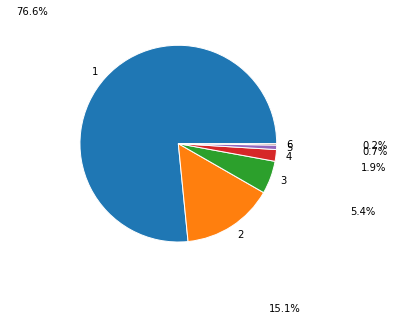

In [65]:
fig1, ax1 = plt.subplots()

pie, _, _ = ax1.pie(values, radius=1,
        labels=labels, autopct='%1.1f%%', pctdistance=2)
ax1.axis('equal')
plt.setp(pie, edgecolor='white')

# plt.savefig(str(FIGPATH / 'misc_figures' / 'feature_overlap.pdf'))
plt.show()

In [66]:
ubiquitous_features = list(x['ubiquitous'])
sorted([x.name for x in ubiquitous_features])

['L858R', 'V600E']

In [67]:
def element_uniqueness_across_kbs(element, as_proportion=False):
    e_sets = core_vdb.get_element_by_source(element)
    count = Counter()
    for s in e_sets.values():
        count.update(s)
    count_of_counts = Counter()
    count_of_counts.update(count.values())
    labels = sorted(count_of_counts.keys())
    if as_proportion:
        d = sum(count_of_counts.values())
        values = [count_of_counts[x]/d for x in labels]
    else:
        values = [count_of_counts[x] for x in labels]
    return dict(zip(labels, values))

In [68]:
element_uniqueness_across_kbs('features', as_proportion=True)

{1: 0.7657841140529531,
 2: 0.15129473377945882,
 3: 0.054116962467267965,
 4: 0.019202793133546697,
 5: 0.007273785277858598,
 6: 0.0023276112889147513}

In [69]:
g_prop = element_uniqueness_across_kbs('genes', as_proportion=True)
f_prop = element_uniqueness_across_kbs('features', as_proportion=True)
di_prop = element_uniqueness_across_kbs('disease', as_proportion=True)
dr_prop = element_uniqueness_across_kbs('drugs', as_proportion=True)
pub_prop = element_uniqueness_across_kbs('publications', as_proportion=True)

In [70]:
labels = ['Genes', 'Features', 'Diseases', 'Drugs*', 'Publications']
N = len(labels)
ind = np.arange(N)
value_sets = [g_prop, f_prop, di_prop, dr_prop, pub_prop]
width = 0.5
plot_sets = [[x.get(i, 0) for x in value_sets] for i in range(1,7)]

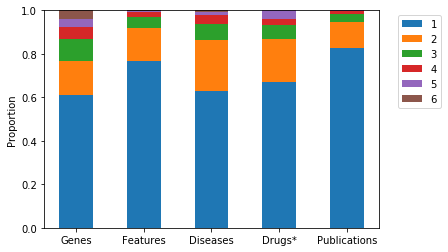

In [71]:
plots = list()
b_sums = np.zeros(N)
for plot_set in plot_sets:
    p = plt.bar(ind, plot_set, width, bottom=b_sums)
    b_sums += np.array(plot_set)
    plots.append(p)

plt.ylabel('Proportion')
plt.xticks(ind, labels)
plt.legend([p[0] for p in plots], range(1,7), bbox_to_anchor=(1.2, 0.5, 0, 0.5))

# plt.savefig(str(FIGPATH / 'misc_figures' / 'elements_overlap.pdf'))
plt.show()

### Tier 1 variants


In [72]:
tier1 = core_vdb.select(lambda x: x.evidence_level in ['A', 'B'])
genes = set()
features = set()
for a in tier1:
    genes.update(a.genes)
    features.update(a.features)
print(len(genes))
print(len(features))

236
1512


### Hierarchical search
Existing method is to find an exact match of any features for an association. Below we demonstrate gains through hierarchical search of GenomicFeatures, a core result of this effort.

In [73]:
hits = core_vdb.search_by_feature(chromosome=7, start=140453136, end=140453136, reference_name='GRCh37')

v600k = [x['best_match']['p'] for x in hits if x['best_match']['feature'].name.endswith('V600K')]
len(v600k)

26

In [74]:
unique_features = set()
x = [x.features for x in core_vdb]
for fset in x:
    unique_features.update(fset)
unique_features = list(unique_features)
len(unique_features)

3437

In [75]:
# This is a computationally expensive operation (~1 minute for the 2800 searches). Could be sped up through indexed searching.

# feature_hits = dict()
# for feature in unique_features:
#     feature_hits[feature] = core_vdb.search_by_feature(genomic_feature=feature)

# New method

feature_hits = core_vdb.search_by_features(genomic_features=unique_features)


In [76]:
ranking = viccdb.ViccDb.MATCH_RANKING
hits_by_type = Counter()
sources_by_type = defaultdict(Counter)
for match_type in ranking:
    typed_hits = [x for x in feature_hits if ranking.index(x['best_match']['type']) <= ranking.index(match_type)]
    hits_by_type[match_type] = len(typed_hits)
    typed_associations_by_query = defaultdict(set)
    for hit in typed_hits:
        typed_associations_by_query[hit['query']].add(hit['association'])
    for associations in typed_associations_by_query.values():
        sources = {association.source for association in associations}
        sources_by_type[len(sources)][match_type] += 1
hits_by_type

Counter({'exact': 21463,
         'positional': 33704,
         'focal': 64142,
         'regional': 285246})

In [77]:
sources_by_type

defaultdict(collections.Counter,
            {1: Counter({'exact': 2361,
                      'positional': 2382,
                      'focal': 2098,
                      'regional': 492}),
             2: Counter({'exact': 467,
                      'positional': 607,
                      'focal': 687,
                      'regional': 439}),
             3: Counter({'exact': 154,
                      'positional': 271,
                      'focal': 305,
                      'regional': 762}),
             4: Counter({'exact': 55,
                      'positional': 106,
                      'focal': 159,
                      'regional': 368}),
             5: Counter({'exact': 20,
                      'positional': 47,
                      'focal': 114,
                      'regional': 930}),
             6: Counter({'exact': 7,
                      'positional': 14,
                      'focal': 72,
                      'regional': 446})})

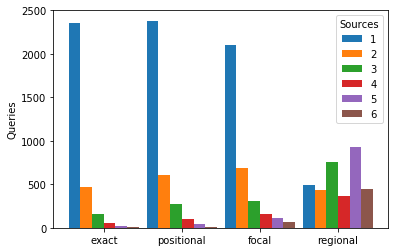

In [78]:
fig, ax = plt.subplots()

source_counts = sorted(sources_by_type)
groups = viccdb.ViccDb.MATCH_RANKING
width = 0.15
plot_elements = list()
ind = np.arange(len(groups))
for i, source_count in enumerate(source_counts):
    type_counts = sources_by_type[source_count]
    x = [type_counts[k] for k in groups]
    p = ax.bar(ind + width*(i-2.5), x, width, label=source_count)
    plot_elements.append(p)
ax.set_xticks(ind)
ax.set_xticklabels(groups)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Sources')
plt.ylabel('Queries')
plt.show()
# fig.savefig(str(FIGPATH / 'misc_figures' / 'search_performance.pdf'), format='pdf')

In [79]:
# feature_hits = core_vdb.search_by_features(genomic_features=ubiquitous_features)
q = {hit['query'] for hit in feature_hits}
len(q)

3437

In [80]:
c = Counter()
for f in unique_features:
    if len(f) > 9 and len(f) < 100:
        l = '10-99'
    elif len(f) >= 100:
        l = '100+'
    else:
        l = len(f)
    c[l] += 1
c

Counter({1: 2510,
         3: 100,
         '100+': 507,
         2: 188,
         '10-99': 108,
         5: 6,
         7: 2,
         4: 7,
         8: 5,
         6: 3,
         9: 1})

### Sequence Ontology

In [81]:
count = Counter()
for association in core_vdb:
    for feature in association.features:
        count[feature.so.get('name', 'Uncategorized')] += 1

In [82]:
count.most_common(10)

[('substitution', 10183),
 ('Uncategorized', 7086),
 ('missense_variant', 2985),
 ('fusion', 2071),
 ('stop_gained', 1214),
 ('feature_amplification', 555),
 ('wild_type', 391),
 ('deletion', 264),
 ('loss_of_function_variant', 242),
 ('copy_number_loss', 207)]

In [83]:
(5052 + 3263) / sum(count.values())

0.3068718630056097

In [84]:
# Associations lacking any sequence ontology ID

def no_soid(association):
    x = [feature.so.get('name', 'Uncategorized') == 'Uncategorized' for feature in association.features]
    return all(x)

no_soid_group = core_vdb.select(no_soid)
no_soid_group.report_groups(core_vdb)

cgi: 25 (2.3% of superset)
civic: 386 (11.6% of superset)
jax: 2432 (42.3% of superset)
molecularmatch: 496 (23.8% of superset)
oncokb: 78 (31.6% of superset)
pmkb: 110 (29.6% of superset)
Total: 3527 (27.4% of superset)


In [85]:
# Associations lacking at least one sequence ontology ID

def missing_soid(association):
    x = [feature.so.get('name', 'Uncategorized') == 'Uncategorized' for feature in association.features]
    return any(x)

missing_soid_group = core_vdb.select(missing_soid)
missing_soid_group.report_groups(core_vdb)

cgi: 16 (1.5% of superset)
civic: 369 (11.0% of superset)
jax: 3199 (55.7% of superset)
molecularmatch: 480 (23.1% of superset)
oncokb: 76 (30.8% of superset)
pmkb: 108 (29.1% of superset)
Total: 4248 (33.0% of superset)


In [86]:
partial_soid_group = missing_soid_group - no_soid_group
partial_soid_group.report_groups(core_vdb)

jax: 777 (13.5% of superset)
molecularmatch: 1 (0.0% of superset)
Total: 778 (6.1% of superset)


In [87]:
partial_soid_group[0].features[2].so

{'hierarchy': ['SO:0000400', 'SO:0001761', 'SO:0001814'],
 'soid': 'SO:0001815',
 'parent_soid': 'SO:0000400',
 'name': 'synonymous',
 'parent_name': 'sequence_attribute'}

### Project GENIE feature match

In [88]:
# Loading Disease graph here for use in GENIE disease matching

import obonet
import networkx

url = 'https://raw.githubusercontent.com/DiseaseOntology/HumanDiseaseOntology/v2018-05-11/src/ontology/HumanDO.obo'
graph = obonet.read_obo(url)

assert networkx.is_directed_acyclic_graph(graph)

In [89]:
so_by_name = {
    "3'Flank": {'name': 'downstream_transcript_variant', 'soid': 'SO:0001987'},
    "3'UTR": {'name': '3_prime_UTR_variant', 'soid': 'SO:0001624'},
    "5'Flank": {'name': 'upstream_transcript_variant', 'soid': 'SO:0001986'},
    "5'UTR": {'name': '5_prime_UTR_variant', 'soid': 'SO:0001623'},
    "Frame_Shift_Del": {'name': 'frameshift_truncation', 'soid': 'SO:0001910'},
    "Frame_Shift_Ins": {'name': 'frameshift_elongation', 'soid': 'SO:0001909'},
    "In_Frame_Del": {'name': 'inframe_deletion', 'soid': 'SO:0001822'},
    "In_Frame_Ins": {'name': 'inframe_insertion', 'soid': 'SO:0001821'},
    "Intron": {'name': 'intron_variant', 'soid': 'SO:0001627'},
    "Missense_Mutation": {'name': 'missense_variant', 'soid': 'SO:0001583'},
    "Nonsense_Mutation": {'name': 'stop_gained', 'soid': 'SO:0001587'},
    "Nonstop_Mutation": {'name': 'stop_lost', 'soid': 'SO:0001578'},
    "Silent": {'name': 'synonymous_variant', 'soid': 'SO:0001819'},
    "Splice_Region": {'name': 'splice_region_variant', 'soid': 'SO:0001630'},
    "Splice_Site": {'name': 'splice_site_variant', 'soid': 'SO:0001629'},
    "Translation_Start_Site": {'name': 'initiator_codon_variant', 'soid': 'SO:0001582'}
}

In [90]:
alias_to_doids = defaultdict(list)
def map_to_doid(graph, doid):
    for _id in graph.predecessors(doid):
        map_to_doid(graph, _id)
    xrefs = graph.node[doid].get('xref', [])
    for xref in xrefs:
        source, xref_id = xref.split(':')
        alias_to_doids[(source, xref_id)].append(doid)

map_to_doid(graph, 'DOID:162') 

In [91]:
oncotree_to_aliases = dict()
oncotree_types_url = 'http://oncotree.mskcc.org/api/tumorTypes'
resp = requests.get(oncotree_types_url, params={'version': 'oncotree_2018_05_01'})
resp.raise_for_status()
oncotree_types = resp.json()
for o_type in oncotree_types:
    oncotree_to_aliases[o_type['code']] = []
    for source, terms in o_type['externalReferences'].items():
        for term in terms:
            oncotree_to_aliases[o_type['code']].append((source, term))

In [92]:
oncotree_to_doids = dict()
for o_term, aliases in oncotree_to_aliases.items():
    if not aliases:
        oncotree_to_doids[o_term] = None
        continue
    doids = set()
    for alias in aliases:
        alias_doids = alias_to_doids.get(alias, False)
        if alias_doids:
            doids.update(alias_doids)
    if doids:
        oncotree_to_doids[o_term] = list(doids)
    else:
        oncotree_to_doids[o_term] = None

In [93]:
patched_doids = {
#     'MAAP': 'DOID:3608',
#     'SCCNOS': 'DOID:1749',
#     'MACR': 'DOID:0050861',
#     'OCSC': 'DOID:0050866',
#     'UDMN': 'DOID:162',
#     'CUP': 'DOID:162',
#     'CUPNOS': 'DOID:162',
#     'MYF': 'DOID:4971',
#     'HGSOC': 'DOID:0050933',
#     'LGSOC': 'DOID:0050933',
#     'SOC': 'DOID:0050933',
#     'PANET': 'DOID:1798',
#     'IMT': 'DOID:0050905',
#     'OPHSC': 'DOID:0050921',
#     'MDS': 'DOID:0050908',
    'ACYC': 'DOID:0080202',
    'HL': 'DOID:8567',
    'SEM': 'DOID:4440'
}

In [94]:
sample_to_patient = dict()
patient_to_samples = defaultdict(list)
sample_to_doid = dict()
sample_oncotree_code = dict()
required_patches = set()
optional_patches = set()
no_patch = set()

with open(DATA_ROOT / 'GENIE_v3' / 'data_clinical_sample_3.0.0.txt') as f:
    for _ in range(4):
        f.readline()    # get past info lines
    reader = csv.DictReader(f, delimiter="\t")
    for row in reader:
        patient = row['PATIENT_ID']
        sample = row['SAMPLE_ID']
        sample_to_patient[sample] = patient
        patient_to_samples[patient].append(sample)
        oncotree_code = row['ONCOTREE_CODE'].upper()
        doids = oncotree_to_doids[oncotree_code]
        if not doids:
            required_patches.add(oncotree_code)
            doid = patched_doids.get(oncotree_code, None)
        elif len(doids) > 1:
            optional_patches.add(oncotree_code)
            doid = patched_doids[oncotree_code]
        else:
            no_patch.add(oncotree_code)
            doid = doids[0]
        sample_to_doid[sample] = doid
        sample_oncotree_code[sample] = oncotree_code
        
patient_to_samples = dict(patient_to_samples)

In [95]:
# Load genie variants
classification_counter = Counter()
genie_features = list()
genie_features_by_patient = defaultdict(list)
genie_features_by_variant = defaultdict(list)
genie_features_by_sample = defaultdict(list)
unfiltered_patients_with_variants = set()
EXCLUDED_CLASSIFICATIONS = [
    'Silent',
    "3'Flank",
    "3'UTR",
    "5'Flank",
    "5'UTR",
    'Intron',
    'Splice_Region'
]
with open(DATA_ROOT / 'GENIE_v3' / 'data_mutations_extended_3.0.0.txt', 'r') as maf:
    sample_list = maf.readline().strip().split(' ')[1:]
    maf_reader = csv.DictReader(maf, delimiter="\t")
    for row in maf_reader:
        start = row['Start_Position']
        end = row['End_Position']
        chromosome = row['Chromosome']
        patient = sample_to_patient[row['Tumor_Sample_Barcode']]
        unfiltered_patients_with_variants.add(patient)
        if row['Variant_Classification'] in EXCLUDED_CLASSIFICATIONS:
            continue
        if row['Reference_Allele'] != row['Tumor_Seq_Allele1']:
            alt = row['Tumor_Seq_Allele1']
        else:
            alt = row['Tumor_Seq_Allele2']
        reference = row['NCBI_Build']
        feature = viccdb.GenomicFeature(
            chromosome=chromosome,
            start=start,
            end=end,
            referenceName=reference,
            name=':'.join([row['Tumor_Sample_Barcode'], row['HGVSp_Short']]),
            geneSymbol=row['Hugo_Symbol'],
            sequence_ontology=so_by_name[row['Variant_Classification']],
            alt=alt
        )
        genie_features.append(feature)
        genie_features_by_patient[patient].append(feature)
        genie_features_by_variant[(reference, chromosome, start, end, alt)].append(feature)
        genie_features_by_sample[row['Tumor_Sample_Barcode']].append(feature)

In [96]:
len(genie_features)

237175

In [97]:
# Do a GENIE feature search across knowledgebase. Huge search operation takes ~5.5 min to complete
from timeit import default_timer
tick = default_timer()
genie_search_results = core_vdb.search_by_features(genie_features)
tock = default_timer()
print(tock-tick)

206.442623164


In [98]:
featured_patients = set(genie_features_by_patient)

In [99]:
print(f'Avg. queries / second: {len(genie_features)/(tock-tick)}')
print(f'Search results: {len(genie_search_results)}')
print(f'Avg. search results / query: {len(genie_search_results)/len(genie_features)}')

Avg. queries / second: 1148.866432546664
Search results: 2316305
Avg. search results / query: 9.766227469168335


In [100]:
genie_feature_lengths = Counter()
for feature in genie_features:
    genie_feature_lengths[len(feature)] += 1

In [101]:
result_size = defaultdict(Counter)
for result in genie_search_results:
    for match_type in ranking:
        if ranking.index(result['best_match']['type']) <= ranking.index(match_type):
            result_size[result['query']][match_type] += 1

In [102]:
print('Percentage of queries with results: {:.1%}'.format(len(result_size) / len(genie_features)))

Percentage of queries with results: 37.3%


In [103]:
exact_match_features = [x for x in result_size 
                        if result_size[x]['exact'] + 
                        result_size[x]['positional'] > 0]
len(exact_match_features)

1870

In [104]:
print('Percentage of queries with exact results: {:.1%}'.format(len(exact_match_features) / len(genie_features)))

Percentage of queries with exact results: 0.8%


In [105]:
data = defaultdict(list)
for feature in genie_features:
    length = len(feature)
    for match_type in ranking:
        data[match_type].append([length, result_size[feature][match_type]])

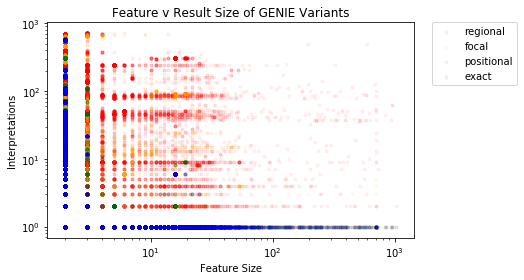

In [106]:
colors = dict(zip(ranking, ['blue', 'green', 'orange', 'red']))
pcs = list()
labels = list()
plt.figure()
plt.xscale('log')
plt.yscale('log')
for t in reversed(ranking):
    coord_pairs = data[t]
    a = np.array(coord_pairs) + 1
    pc = plt.scatter(a[:,0], a[:,1], marker='.', color=colors[t], alpha=0.05)
    pcs.append(pc)
    labels.append(t)
plt.xlabel('Feature Size')
plt.ylabel('Interpretations')
plt.title('Feature v Result Size of GENIE Variants')
plt.legend(pcs, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout() # drops legend :-/
# plt.savefig(str(FIGPATH / 'feature_v_result_size_genie.pdf'))
# plt.savefig(str(FIGPATH / 'feature_v_result_size_genie.png'))
plt.show()

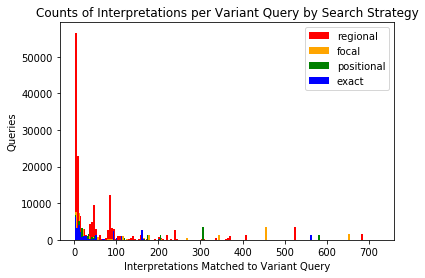

In [107]:
for t in reversed(ranking):
    data = [result_size[q][t] for q in genie_features
            if result_size[q][t] > 0
           ]
    plt.hist(data, alpha=1, label=t, color=colors[t], bins=150)
plt.xlabel('Interpretations Matched to Variant Query')
plt.ylabel('Queries')
plt.title('Counts of Interpretations per Variant Query by Search Strategy')
plt.legend()
# plt.savefig(str(FIGPATH / 'genie_interpretation_v_query_all.pdf'))
plt.show()

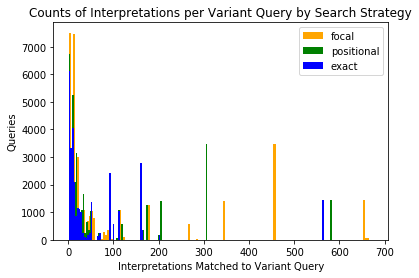

In [108]:
notables = Counter()
for t in reversed(ranking[:3]):
    data = [result_size[q][t] for q in genie_features
            if result_size[q][t] > 0
           ]
    for q in genie_features:
        if result_size[q][t] > 90:
            notables[(q,t)] += 1
    plt.hist(data, alpha=1, label=t, color=colors[t], bins=150)
plt.title('Counts of Interpretations per Variant Query by Search Strategy')
plt.xlabel('Interpretations Matched to Variant Query')
plt.ylabel('Queries')
plt.legend()
# plt.savefig(str(FIGPATH / 'genie_interpretation_v_query_no_regional.pdf'))
plt.show()

In [109]:
coord_q = dict()
for notable in notables.most_common(len(notables)):
    if notable[1] > 950:
        feature = notable[0][0]
        t = notable[0][1]
        queries = notable[1]
        HGVSp = feature.name.split(':')[1]
        coord_q[(result_size[feature][t], queries)] = (feature, t)
    else:
        break
for coord in sorted(coord_q):
    feature, t = coord_q[coord]
    HGVSp = feature.name.split(':')[1]
    queries = coord[1]
    print(f'({result_size[feature][t]}, {queries}): {feature.gene_symbol} {HGVSp} ({t})')

(92, 1425): KRAS p.G12V (exact)
(94, 998): KRAS p.G12C (exact)
(111, 1062): PIK3CA p.E545K (exact)
(113, 1062): PIK3CA p.E545K (positional)
(117, 1062): PIK3CA p.E545K (focal)
(160, 1080): PIK3CA p.H1047R (exact)
(161, 1720): KRAS p.G12D (exact)
(174, 1080): PIK3CA p.H1047R (positional)
(178, 1080): PIK3CA p.H1047R (focal)
(205, 998): KRAS p.G12C (positional)
(308, 1425): KRAS p.G12V (positional)
(308, 1720): KRAS p.G12D (positional)
(343, 998): KRAS p.G12C (focal)
(457, 1425): KRAS p.G12V (focal)
(457, 1720): KRAS p.G12D (focal)
(565, 1439): BRAF p.V600E (exact)
(584, 1439): BRAF p.V600E (positional)
(655, 1439): BRAF p.V600E (focal)


## Disease

In [110]:
oncotree_codes = {x['code'] for x in oncotree_types}
print(f'There are {len(oncotree_codes)} diseases in oncotree.')
no_xrefs = {x for x, v in oncotree_to_aliases.items() if not v}
print(f'Of these, {len(no_xrefs)} have no xrefs.')
print(f'{len(required_patches)} of {len(required_patches | no_patch)} oncotree diseases from GENIE do not automatically map to doid.')
print(f'Of these, {len(required_patches & no_xrefs)} have no xrefs.')
a = np.array([
        [len(required_patches & no_xrefs), len(required_patches - no_xrefs)],
        [len(oncotree_codes & no_xrefs), len(oncotree_codes - no_xrefs)]
         ])
print(a)
stats.fisher_exact(a)

There are 667 diseases in oncotree.
Of these, 133 have no xrefs.
286 of 539 oncotree diseases from GENIE do not automatically map to doid.
Of these, 96 have no xrefs.
[[ 96 190]
 [133 534]]


(2.0286505738029286, 1.0654351125278186e-05)

In [111]:
c = Counter()
for x in core_vdb:
    try:
        c[x.disease.source] += 1
    except AttributeError:
        c[None] += 1
c

Counter({'http://purl.obolibrary.org/obo/doid': 12573,
         'MEDDRA': 32,
         'SNOMEDCT': 24,
         None: 1,
         'OMIM': 1,
         'DOID': 213,
         'EVS': 8,
         'ICD10CM': 3,
         'RID': 1})

In [112]:
doid = core_vdb.select(lambda x: x.disease is not None and x.disease.id.startswith('DOID:'))

In [113]:
# Problem with number of entries from jax reporting "cancer" as doid type
doid.select(lambda x: x.disease.id == 'DOID:162').report_groups(core_vdb)

cgi: 106 (9.9% of superset)
civic: 81 (2.4% of superset)
jax: 1352 (23.5% of superset)
oncokb: 15 (6.1% of superset)
Total: 1554 (12.1% of superset)


In [114]:
id_to_name = {id_: data['name'] for id_, data in graph.nodes(data=True)}

In [115]:
c = Counter()
for x in doid:
    try:
        c[x.disease.id] += 1
    except AttributeError:
        c[None] += 1
for k, v in c.most_common(20):
    print(f'{id_to_name[k]}: {v}')

cancer: 1554
lung adenocarcinoma: 1415
breast cancer: 1089
non-small cell lung carcinoma: 1011
colorectal cancer: 976
melanoma: 659
von Hippel-Lindau disease: 566
acute myeloid leukemia: 419
rectal neoplasm: 366
chronic myeloid leukemia: 251
lung cancer: 210
gastrointestinal stromal tumor: 194
skin melanoma: 162
ovarian cancer: 156
stomach cancer: 135
Her2-receptor positive breast cancer: 132
colon cancer: 120
glioblastoma multiforme: 116
endometrial cancer: 113
head and neck squamous cell carcinoma: 107


In [116]:
organ_system_ids = graph.predecessors('DOID:0050686')
benign_and_premalignant_ids = ['DOID:0060072', 'DOID:0060071']
cell_type_cancer_id = 'DOID:0050687'
cancer_id = 'DOID:162'

In [117]:
organ_system = dict()
benign_and_premalignant = dict()

def assign_to_id(ids, id_, d):
    if len(ids) == 0:
        return
    for i in ids:
        d[i] = id_
        assign_to_id(graph.predecessors(i), id_, d)
    return 

for organ_id in (organ_system_ids + [cell_type_cancer_id]):
    assign_to_id(graph.predecessors(organ_id), organ_id, organ_system)
    organ_system[organ_id] = organ_id

for id_ in benign_and_premalignant_ids:
    assign_to_id(graph.predecessors(id_), id_, benign_and_premalignant)
    benign_and_premalignant[id_] = id_
    


In [118]:
return_id = organ_system['DOID:0050615']
graph.node[return_id]

{'name': 'respiratory system cancer',
 'def': '"An organ system cancer located_in the respiratory system that is characterized by uncontrolled cellular proliferation in the respiratory tract." [url:http\\://en.wikipedia.org/wiki/Respiratory_tract_neoplasm]',
 'is_a': ['DOID:0050686']}

In [119]:
normalized_disease = core_vdb.select(lambda x: x.disease is not None)
normalized_disease.report_groups(core_vdb)

cgi: 1072 (100.0% of superset)
civic: 3339 (100.0% of superset)
jax: 5746 (100.0% of superset)
molecularmatch: 2080 (100.0% of superset)
oncokb: 247 (100.0% of superset)
pmkb: 371 (100.0% of superset)
Total: 12855 (100.0% of superset)


In [120]:
do_sourced = normalized_disease.select(lambda x: x.disease.source in ['DOID', 'http://purl.obolibrary.org/obo/doid'])

In [121]:
do_sourced.report_groups(core_vdb)

cgi: 1072 (100.0% of superset)
civic: 3304 (98.9% of superset)
jax: 5745 (100.0% of superset)
molecularmatch: 2080 (100.0% of superset)
oncokb: 239 (96.8% of superset)
pmkb: 346 (93.3% of superset)
Total: 12786 (99.5% of superset)


In [122]:
cancer_organ_interpretations = do_sourced.select(lambda x: organ_system.get(x.disease.id, False))
benign_premalignant_interpretations = do_sourced.select(lambda x: benign_and_premalignant.get(x.disease.id, False))
cancer_interpretations = do_sourced.select(lambda x: x.disease.id == cancer_id)
other_interpretations = do_sourced - cancer_organ_interpretations - benign_premalignant_interpretations - cancer_interpretations

In [123]:
cancer_organ_interpretations.report_groups(do_sourced)

cgi: 887 (82.7% of superset)
civic: 2602 (78.8% of superset)
jax: 4388 (76.4% of superset)
molecularmatch: 1714 (82.4% of superset)
oncokb: 215 (90.0% of superset)
pmkb: 334 (96.5% of superset)
Total: 10140 (79.3% of superset)


In [124]:
benign_premalignant_interpretations.report_groups(do_sourced)

cgi: 56 (5.2% of superset)
civic: 570 (17.3% of superset)
jax: 5 (0.1% of superset)
molecularmatch: 366 (17.6% of superset)
pmkb: 2 (0.6% of superset)
Total: 999 (7.8% of superset)


In [125]:
cancer_interpretations.report_groups(do_sourced)

cgi: 106 (9.9% of superset)
civic: 81 (2.5% of superset)
jax: 1352 (23.5% of superset)
oncokb: 15 (6.3% of superset)
Total: 1554 (12.2% of superset)


In [126]:
other_interpretations.report_groups(do_sourced)

cgi: 23 (2.1% of superset)
civic: 51 (1.5% of superset)
oncokb: 9 (3.8% of superset)
pmkb: 10 (2.9% of superset)
Total: 93 (0.7% of superset)


In [127]:
x = other_interpretations.select(lambda x: x.disease.id.split(':')[0] != 'DOID')
x.report_groups(do_sourced)

civic: 2 (0.1% of superset)
oncokb: 2 (0.8% of superset)
pmkb: 8 (2.3% of superset)
Total: 12 (0.1% of superset)


In [128]:
c = Counter()
for i in x:
    c[i.disease.id.split(':')[0]] += 1
c

Counter({'HP': 12})

In [129]:
entry = x.by_source('civic')[0]
print(entry.disease.source)
print(entry.disease.id)
print(entry.disease.term)
print(entry['feature_names'])

http://purl.obolibrary.org/obo/doid
HP:0011779
Anaplastic thyroid carcinoma
EID3744


In [130]:
c = Counter()
for association in cancer_organ_interpretations:
    disease_id = association.disease.id
    organ_id = organ_system[disease_id]
    c[organ_id] += 1

In [131]:
for k, v in c.most_common(13):
    print(f'{id_to_name[k]}: {v}')

respiratory system cancer: 2749
gastrointestinal system cancer: 1757
thoracic cancer: 1452
immune system cancer: 1344
cell type cancer: 1064
reproductive organ cancer: 519
endocrine gland cancer: 356
urinary system cancer: 253
nervous system cancer: 212
integumentary system cancer: 196
head and neck cancer: 136
musculoskeletal system cancer: 101
peritoneum cancer: 1


In [132]:
p_cancer = cancer_organ_interpretations.select(lambda x: id_to_name[organ_system[x.disease.id]] == 'peritoneum cancer')[0]
print(p_cancer.disease)
print(p_cancer.source)
print(p_cancer.description)

http://purl.obolibrary.org/obo/doid: DOID:1725
jax
In a preclinical study, the combination of APR-246 and Platinol (cisplatin) resulted in strong synergism, thereby reducing cell viability in patient derived peritoneum cancer cells harboring TP53 C135Y in culture (PMID: 27179933). 


In [133]:
len(set(organ_system.values()))

15

In [134]:
with open(DATA_ROOT / 'TopNodes_DOcancerslim_3_18.json', 'r') as f:
    result = json.load(f)
    nodes = result['graphs'][0]['nodes']

In [135]:
nodes[0]['id'].split('/')[-1].replace('_', ':')

'DOID:1324'

In [136]:
topnodes_docancerslim = list()
doid_re = re.compile(r'DOID:\d+')

for node in nodes:
    doid = node['id'].split('/')[-1].replace('_', ':')
    if doid_re.match(doid):
        topnodes_docancerslim.append(doid)

In [137]:
len(topnodes_docancerslim)

58

In [138]:
def assign_to_nearest_id(ids, id_, d, terminals):
    if len(ids) == 0:
        return
    for i in ids:
        if i in terminals:
            assignment = i
        else:
            assignment = id_
        d[i] = assignment
        assign_to_nearest_id(graph.predecessors(i), assignment, d, terminals)
    return

topnode_map = dict()
assign_to_nearest_id(['DOID:162'], 'DOID:162', topnode_map, topnodes_docancerslim)

In [139]:
cancer_counts = Counter()

cancer_associations = do_sourced.select(
    lambda x: topnode_map.get(x.disease.id, False))

for association in cancer_associations:
    disease_id = association.disease.id
    topnode_id = topnode_map[disease_id]
    cancer_counts[topnode_id] += 1

cancer_associations.report_groups(do_sourced)

cgi: 993 (92.6% of superset)
civic: 2683 (81.2% of superset)
jax: 5740 (99.9% of superset)
molecularmatch: 1714 (82.4% of superset)
oncokb: 230 (96.2% of superset)
pmkb: 334 (96.5% of superset)
Total: 11694 (91.5% of superset)


In [140]:
other_associations = do_sourced - cancer_associations
other_associations.report_groups(do_sourced)

cgi: 79 (7.4% of superset)
civic: 621 (18.8% of superset)
jax: 5 (0.1% of superset)
molecularmatch: 366 (17.6% of superset)
oncokb: 9 (3.8% of superset)
pmkb: 12 (3.5% of superset)
Total: 1092 (8.5% of superset)


In [141]:
len(cancer_counts)

48

In [142]:
for k, v in cancer_counts.most_common(48):
    print(f'{id_to_name[k]}: {v}')
    

lung cancer: 2748
cancer: 1727
breast cancer: 1452
hematologic cancer: 1330
large intestine cancer: 1073
melanoma: 661
gastrointestinal system cancer: 216
malignant glioma: 213
ovarian cancer: 207
stomach cancer: 205
skin cancer: 196
thyroid cancer: 174
pancreatic cancer: 166
uterine cancer: 156
urinary bladder cancer: 144
colon cancer: 136
head and neck cancer: 136
prostate cancer: 129
kidney cancer: 101
peripheral nervous system neoplasm: 90
ocular cancer: 56
connective tissue cancer: 53
brain cancer: 50
bone cancer: 44
bile duct cancer: 38
sarcoma: 36
esophageal cancer: 36
liver cancer: 29
cervical cancer: 17
thymus cancer: 12
meningioma: 11
adrenal gland cancer: 10
pharynx cancer: 8
salivary gland cancer: 6
endocrine gland cancer: 6
oral cavity cancer: 4
muscle cancer: 4
appendix cancer: 2
rectum cancer: 2
vulva cancer: 2
larynx cancer: 1
ureter cancer: 1
duodenum cancer: 1
penile cancer: 1
intestinal cancer: 1
peritoneum cancer: 1
vaginal cancer: 1
fallopian tube cancer: 1


In [143]:
def write_disease_counts(file_handle, disease_counter):
    writer = csv.writer(file_handle)
    s = sum(disease_counter.values())
    writer.writerow(['DOID', 'Disease Name', 'Interpretations', 'Percentage'])
    for k, v in disease_counter.most_common(len(disease_counter)):
        writer.writerow([k, id_to_name[k], v, '{:.2%}'.format(v/s)])

In [144]:
with open('out/interpretation_disease_topnode_counts.csv', 'w') as f:
    write_disease_counts(f, cancer_counts)

In [145]:
# Benign

benign_id = 'DOID:0060072'
benign = dict()

assign_to_id(graph.predecessors(benign_id), benign_id, benign)
benign[benign_id] = benign_id

benign_associations = other_associations.select(
    lambda x: benign.get(x.disease.id, False))

other_associations = other_associations - benign_associations
benign_associations.report_groups(do_sourced)

cgi: 56 (5.2% of superset)
civic: 570 (17.3% of superset)
jax: 4 (0.1% of superset)
molecularmatch: 366 (17.6% of superset)
pmkb: 2 (0.6% of superset)
Total: 998 (7.8% of superset)


In [146]:
# pre-malignant

premalignant_id = 'DOID:0060071'
premalignant = dict()

assign_to_id(graph.predecessors(premalignant_id), premalignant_id, premalignant)
premalignant[premalignant_id] = premalignant_id

premalignant_associations = other_associations.select(
    lambda x: premalignant.get(x.disease.id, False))

premalignant_associations.report_groups(do_sourced)

jax: 1 (0.0% of superset)
Total: 1 (0.0% of superset)


In [147]:
# Make data

common_cancers = list(filter(lambda x: x[0] != "DOID:162", cancer_counts.most_common(6)))

interpretation_group_names=[id_to_name[x[0]] for x in common_cancers] + ['other cancers'] + ['benign', 'other disease']
common_cancer_values = [x[1] for x in common_cancers]
interpretation_group_sizes=common_cancer_values + [sum(cancer_counts.values()) - sum(common_cancer_values),
                                      len(benign_associations),
                                      len(other_associations)]


In [148]:
incidence_by_topnode = Counter()
mortality_by_topnode = Counter()
p = (len(benign_associations) + len(other_associations)) / len(do_sourced)
with open(DATA_ROOT / 'Cancer Incidence and Mortality 2018.csv', 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        incidence_by_topnode[topnode_map[row['DOID']]] += int(row['New Cases'])
        mortality_by_topnode[topnode_map[row['DOID']]] += int(row['Estimated Deaths'])

In [149]:
def select_by_percent(counter, percent=5):
    assert percent <= 100
    s = sum(counter.values())
    out = Counter()
    for k, v in counter.most_common(len(counter)):
        if k == "DOID:162":
            continue
        p = v/s
        if p*100 < percent:
            break
        out[k] = v
        print(f'{id_to_name[k]}: {p}')
    return out

In [150]:
with open('out/NCI_disease_topnode_counts.csv', 'w') as f:
    writer = csv.writer(f)
    s1 = sum(incidence_by_topnode.values())
    s2 = sum(mortality_by_topnode.values())
    writer.writerow(
        ['DOID', 'Disease Name', 
         'Estimated New Cases, 2018, US', 'Percentage',
         'Estimated Deaths, 2018, US', 'Percentage'
        ])
    for k, v in incidence_by_topnode.most_common(len(incidence_by_topnode)):
        v2 = mortality_by_topnode[k]
        writer.writerow(
            [k, id_to_name[k], 
             v, '{:.2%}'.format(v/s1),
             v2, '{:.2%}'.format(v2/s2)
            ])

In [151]:
prevalent_incidence = select_by_percent(incidence_by_topnode)

breast cancer: 0.15482179387443457
lung cancer: 0.13486040280058778
hematologic cancer: 0.10041202062984413
prostate cancer: 0.09490304549514507
skin cancer: 0.05736594923214337
colon cancer: 0.056023280606217765


In [152]:
prevalent_mortality = select_by_percent(mortality_by_topnode)

lung cancer: 0.25269011219736237
hematologic cancer: 0.09530214552850863
colon cancer: 0.08304901253198609
pancreatic cancer: 0.07271504494455744
breast cancer: 0.0679089298602454


In [153]:
len(incidence_by_topnode)

30

In [154]:
incidence_group_names = [id_to_name[x] for x in prevalent_incidence] + ['other cancers']
incidence_group_sizes = list(prevalent_incidence.values()) + [
                            sum(incidence_by_topnode.values()) - sum(prevalent_incidence.values())
                        ]

In [155]:
mortality_group_names = [id_to_name[x] for x in prevalent_mortality] + ['other cancers']
mortality_group_sizes = list(prevalent_mortality.values()) + [
                            sum(mortality_by_topnode.values()) - sum(prevalent_mortality.values())
                        ]

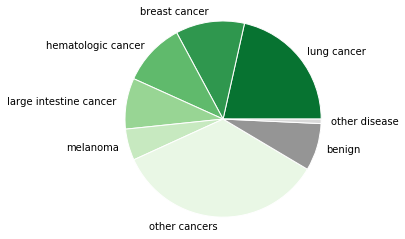

In [156]:
RADIUS=1

greens = plt.cm.Greens
grays = plt.cm.Greys
blues = plt.cm.Blues
reds = plt.cm.Reds

colors = [
    greens(.85),
    greens(.7),
    greens(.55),
    greens(.4),
    greens(.25),
    greens(.1),
    grays(.5),
    grays(.25)
]
fig1, ax1 = plt.subplots()
pie, _ = ax1.pie(interpretation_group_sizes, colors=colors, radius=RADIUS,
        labels=interpretation_group_names)
ax1.axis('equal')
plt.setp(pie, edgecolor='white')

# plt.savefig(str(FIGPATH / 'disease_interpretations.pdf'))
plt.show()

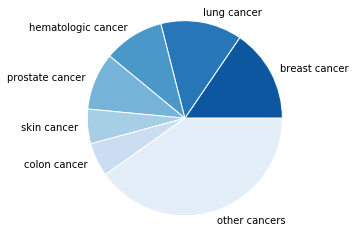

In [157]:
colors = [
    blues(.85),
    blues(.75 * 5/6 + .1),
    blues(.75 * 4/6 + .1),
    blues(.75 * 3/6 + .1),
    blues(.75 * 2/6 + .1),
    blues(.75 * 1/6 + .1),
    blues(.1)
]

fig1, ax1 = plt.subplots()
pie, _ = ax1.pie(incidence_group_sizes, colors=colors, radius=RADIUS,
        labels=incidence_group_names)

ax1.axis('equal')
plt.setp(pie, edgecolor='white')

# plt.savefig(str(FIGPATH / 'disease_incidence.pdf'))
plt.show()

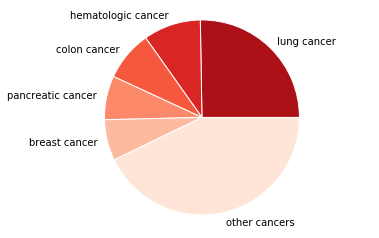

In [158]:
colors = [
    reds(.85),
    reds(.7),
    reds(.55),
    reds(.4),
    reds(.25),
    reds(.1)
]

fig1, ax1 = plt.subplots()
pie, _ = ax1.pie(mortality_group_sizes, colors=colors, radius=RADIUS,
        labels=mortality_group_names)

ax1.axis('equal')
plt.setp(pie, edgecolor='white')

# plt.savefig(str(FIGPATH / 'disease_mortality.pdf'))
plt.show()

In [159]:
b = benign_associations[0]
print(b.description)
print(b.disease)
print(b.disease.id)
print(b.source)

KRAS Q61L confers resistance to Cetuximab in patients with Neoplasm of colorectum
http://purl.obolibrary.org/obo/doid: DOID:1984
DOID:1984
molecularmatch


In [160]:
# MAKE A DISEASE/GENE PLOT: heatmap of ubiquitous gene x disease, heat = tier 1 evidence

### Export disease counts for supplementary table

In [161]:
# d = cancer_associations.get_element_by_source('disease')
# d2 = benign_associations.get_element_by_source('disease')
d = defaultdict(Counter)
d2 = defaultdict(Counter)
d3 = defaultdict(Counter)
for association in cancer_associations:
    disease = association.disease
    source = association.source
    d[source][disease] += 1
for association in benign_associations:
    disease = association.disease
    source = association.source
    d2[source][disease] += 1
for association in other_associations:
    disease = association.disease
    source = association.source
    d3[source][disease] += 1
sorted(d.keys())

['cgi', 'civic', 'jax', 'molecularmatch', 'oncokb', 'pmkb']

In [162]:
diseases = set()
cancer_diseases = set()
benign_diseases = set()
other_diseases = set()
for x in d.values():
    cancer_diseases.update(x)
    diseases.update(x)
for x in d2.values():
    benign_diseases.update(x)
    diseases.update(x)
for x in d3.values():
    other_diseases.update(x)
    diseases.update(x)

with open(FIGPATH / 'Data' / 'disease_counts.csv', 'w') as f:
    header = ['disease', 'doid', 'TopNode_disease', 'TopNode_doid'] + sorted(d.keys())
    writer = csv.DictWriter(f, fieldnames=header)
    writer.writeheader()
    counts = dict()
    for s, v in d.items():
        counts[s] = Counter(v)
    for s, v in d2.items():
        counts[s].update(Counter(v))
    for s, v in d3.items():
        counts[s].update(Counter(v))
    for disease in diseases:
        if disease in cancer_diseases:
            tn_id = topnode_map[disease.id]
            tn_name = id_to_name[tn_id]
        elif disease in benign_diseases:
            tn_id = benign[disease.id]
            tn_name = id_to_name[tn_id]
        elif disease in other_diseases:
            tn_id = None
            tn_name = 'other'
        else:
            raise ValueError
        if not disease.id.startswith('DOID'):
            continue
        try:
            row = {
                'disease': id_to_name[disease.id],
                'doid': disease.id,
                'TopNode_disease': tn_name,
                'TopNode_doid': tn_id
            }
        except KeyError:
            print(f'Failed to find name for {disease.id}: {disease.name}')
            continue
        for s in d:
            row[s] = counts[s][disease]
        writer.writerow(row)

## Clinical actionability improvement

In [163]:
# Stacked bar (Actionability type):
#  Group 1: Average actionability, variant only (SD whiskers?)
#  Group 2: Aggregate actionability, variant only (p-value bar?; with narrow search)
#  Group 3: Aggregate actionability, variant only (p-value bar?; with broad search)
#  Group 4: Average actionability, variant + disease
#  Group 5: Aggregate actionability, variant + disease (p-value bar?; with narrow search)
#  Group 6: Aggregate actionability, variant + disease (p-value bar?; with broad search)

In [164]:
# Actionability by disease type
from collections import defaultdict

In [165]:
genie_search_results[0]['query']

<class 'vicckb.model.GenomicFeature'>: GRCh37:1:11168239:11168239:GENIE-GRCC-xz6vj39l-sample-a:p.W2545R

In [166]:
genie_features_by_patient['GENIE-NKI-01CH']

[<class 'vicckb.model.GenomicFeature'>: GRCh37:5:149433746:149433766:GENIE-NKI-01CH-ELEJ:p.S929_S935del,
 <class 'vicckb.model.GenomicFeature'>: GRCh37:13:49039246:49039246:GENIE-NKI-01CH-ELEJ:,
 <class 'vicckb.model.GenomicFeature'>: GRCh37:17:7577573:7577573:GENIE-NKI-01CH-ELEJ:p.Y236*]

In [167]:
genie_search_results_by_query = defaultdict(list)
for result in genie_search_results:
    genie_search_results_by_query[result['query']].append(result)

## Interpretations and Actionability

In [168]:
tier1_disease_gene = Counter()
all_disease_gene = Counter()
for association in core_vdb:
    try:
        disease = id_to_name[topnode_map[association.disease.id]]
    except (KeyError, AttributeError):
        continue
    level = association.evidence_level
    for gene in association.genes:
        k = (gene.gene_symbol, disease)
        if level in ['A', 'B']:
            tier1_disease_gene[k] += 1
        all_disease_gene[k] += 1

In [169]:
(gene, disease), count = tier1_disease_gene.most_common(30)[0]

In [170]:
import seaborn as sns

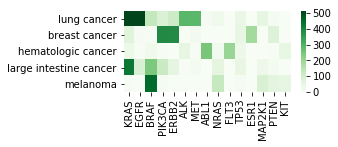

In [171]:
f, ax = plt.subplots(figsize=(3.75, 1.5))
genes = Counter()
diseases = interpretation_group_names[:5]
i = 0
for (gene, disease), count in all_disease_gene.most_common(len(all_disease_gene)):
    i += 1
    if disease not in diseases:
        continue
    genes[gene] += count
    
genes = [x[0] for x in genes.most_common(15)]
        
heat_array_all = np.zeros((len(diseases),len(genes)))
for i in range(len(genes)):
    for j in range(len(diseases)):
        heat_array_all[j][i] = all_disease_gene.get((genes[i], diseases[j]), 0)

sns.heatmap(heat_array_all, xticklabels=genes, yticklabels=diseases, robust=True, cmap='Greens')

# f.savefig(str(FIGPATH / 'misc_figures' / 'all_disease_gene_heatmap.pdf'), format='pdf')

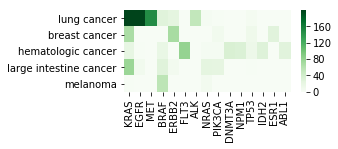

In [172]:
# genes = [x.gene_symbol for x in with_genes.element_by_source_stats('genes')['ubiquitous']]
f, ax = plt.subplots(figsize=(3.75, 1.5))
genes = Counter()
diseases = interpretation_group_names[:5]
i = 0
for (gene, disease), count in tier1_disease_gene.most_common(len(tier1_disease_gene)):
    i += 1
    if disease not in diseases:
        continue
    genes[gene] += count
    
genes = [x[0] for x in genes.most_common(15)]
        
heat_array_tier1 = np.zeros((len(diseases),len(genes)))
for i in range(len(genes)):
    for j in range(len(diseases)):
        heat_array_tier1[j][i] = tier1_disease_gene.get((genes[i], diseases[j]), 0)


sns.heatmap(heat_array_tier1, xticklabels=genes, yticklabels=diseases, robust=True, cmap='Greens')

# f.savefig(str(FIGPATH / 'misc_figures' / 'tier1_disease_gene_heatmap.pdf'), format='pdf')

In [173]:
all_df = pd.DataFrame.from_dict(all_disease_gene, orient='index')
tier1_df = pd.DataFrame.from_dict(tier1_disease_gene, orient='index')

In [174]:
merged_df = all_df.merge(tier1_df, left_index=True, right_index=True, how='outer').fillna(0)

In [175]:
merged_df.columns = ['all_interpretations', 'tier1_interpretations']

In [176]:
sns.set_style("ticks")

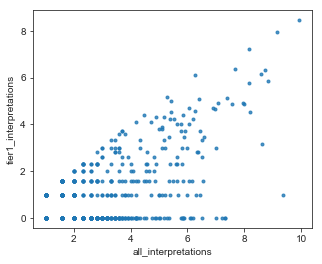

In [177]:
f, ax = plt.subplots(figsize=(5, 4))

ax = sns.regplot(x='all_interpretations', y='tier1_interpretations', fit_reg=False, data=np.log2(merged_df + 1),
                 marker='.'
                )

In [178]:
tdf = np.log2(merged_df + 1)

In [179]:
tdf.loc[(tdf['all_interpretations'] > 8) & (tdf['tier1_interpretations'] < 4)]

,all_interpretations,tier1_interpretations
"(ALK, cancer)",9.359750,1.000000
"(PIK3CA, breast cancer)",8.611025,3.169925


In [180]:
with open(DATA_ROOT / 'GENIE_v3' / 'data_clinical_sample_3.0.0.txt') as f, open(OUTPATH / 'genie_mapping.csv', 'w') as out_f:
    for _ in range(4):
        f.readline()    # get past info lines
    reader = csv.DictReader(f, delimiter="\t")
    writer = csv.writer(out_f)
    header = ['PATIENT_ID',
              'SAMPLE_ID',
              'ONCOTREE_CODE',
              'SPECIFIC_CANCER_TYPE',
              'CANCER_TYPE',
              'DOID',
              'DO_NAME',
              'TOPNODE_DOID',
              'TOPNODE_NAME'
             ]
    writer.writerow(header)
    for row in reader:
        patient = row['PATIENT_ID']
        sample = row['SAMPLE_ID']
        oncotree_code = row['ONCOTREE_CODE'].upper()
        cancer_type_detailed = row['CANCER_TYPE_DETAILED']
        cancer_type = row['CANCER_TYPE']
        doid = sample_to_doid[sample]
        do_name = id_to_name.get(doid, None)
        topnode_id = topnode_map.get(doid, None)
        topnode_name = id_to_name.get(topnode_id, None)
        writer.writerow([
                patient,
                sample,
                oncotree_code,
                cancer_type_detailed,
                cancer_type,
                doid,
                do_name,
                topnode_id,
                topnode_name
            ])

In [181]:
dd_score = dict()

def disease_dist(doid_1, doid_2):
    try:
        key = tuple(sorted([doid_1, doid_2]))
    except TypeError:
        return -1
    if key in dd_score:
        return dd_score[key]
    best_score = None
    queue = [(doid_1, doid_2, 0, False), (doid_2, doid_1, 0, False)]
    while queue:
        current, target, distance, topnode_hit = queue.pop()
        if current == target:
            if best_score is None or distance < best_score:
                best_score = distance
        else:
            if topnode_hit:
                distance += 1
                topnode_hit = False
            if current in topnode_map and current == topnode_map[current]:
                topnode_hit = True
            try:
                for successor in graph.successors(current):
                    queue.append((successor, target, distance, topnode_hit))
            except networkx.NetworkXError:
                pass
    if best_score is None:
        best_score = -1
    dd_score[key] = best_score
    return best_score

In [182]:
SOURCES = tuple(sorted(core_vdb.sources))
patient_actionability = dict()
disease_actionability_count = Counter()
sample_disease_count = Counter()
disease_feature_count = Counter()
patients_with_topnode = set()
cgi_diseases_with_patient_match = defaultdict(set)
ALL_PATIENT_COUNT = len(patient_to_samples)
for patient in featured_patients:
    samples = patient_to_samples[patient]
    actionable = np.zeros(40) # [0..5]: sources (exact), 6: combined, 7: deprecated. 
                              # +8 for +disease +16 for +dis/tier1
                              # +24 for broad variant, +32 for broad disease
    for sample in samples:
        sample_disease = sample_to_doid[sample]
        features = genie_features_by_sample[sample]
        evidence_level = None
        for feature in features:
            results = genie_search_results_by_query.get(feature, [])
            for result in results:
                best = result['best_match']
                dd = disease_dist(result['association'].disease.id, sample_disease)
                level = result['association']['association']['evidence_label']
                tier1 = level in ['A', 'B']
                idx = SOURCES.index(result['association']['source'])
                if best['type'] in ['exact', 'positional']:
                    actionable[idx] = 1
                    actionable[6] = 1
                    if result['association'].source == 'cgi' and sample_disease:
                            cgi_diseases_with_patient_match[patient].add((result['association'].disease.id, sample_disease))
                    if dd == 0:
                        actionable[14] = 1
                        actionable[idx + 8] = 1
                        if tier1:
                            actionable[22] = 1
                            actionable[idx + 16] = 1
                        if evidence_level is None or level < evidence_level:
                            evidence_level = level
                actionable[idx + 24] = 1
                actionable[30] = 1
                if dd >= 0:
                    actionable[idx + 32] = 1
                    actionable[38] = 1
        try:
            top_disease = id_to_name[topnode_map[sample_disease]]
            sample_disease_count[top_disease] += 1
            disease_feature_count[top_disease] += len(features)
        except KeyError:
            top_disease = None
        if evidence_level is not None and top_disease is not None:
            disease_actionability_count[(top_disease, evidence_level)] += 1
        if top_disease is not None:
            patients_with_topnode.add(sample_to_patient[sample])
    patient_actionability[patient] = actionable
    
actionability_grid = np.array(list(patient_actionability.values()))
actionability_sum = actionability_grid.sum(axis=0)

### investigating CGI discrepancy

In [183]:
# len(cgi_diseases_with_patient_match)
patient_disease_match = dict()
for patient, matches in cgi_diseases_with_patient_match.items():
    best_score = -1
    for cgi_diseases in matches:
        score = disease_dist(*cgi_diseases)
        if score >= 0:
            if best_score == -1:
                best_score = score
            elif score < best_score:
                best_score = score
    if best_score < 0:
        patient_disease_match[patient] = {'total': 0}
        patient_diseases = set([x[1] for x in matches])
        for disease in patient_diseases:
            patient_disease_match[patient][disease] = Counter()
        for cgi_diseases in matches:
            patient_disease_match[patient][cgi_diseases[1]][cgi_diseases[0]] += 1
            patient_disease_match[patient]['total'] += 1

In [184]:
# for patient in sorted(patient_disease_match, key=lambda x: patient_disease_match[x]['total'], reverse=True):
#     print(patient, patient_disease_match[patient]['total'])
disease_counter = Counter()
for patient in patient_disease_match:
    for disease in patient_disease_match[patient]:
        disease_counter[disease] += 1
disease_counter.most_common(30)

[('total', 5814),
 ('DOID:234', 902),
 ('DOID:3910', 889),
 ('DOID:3008', 642),
 ('DOID:5672', 295),
 ('DOID:4074', 268),
 ('DOID:1996', 209),
 ('DOID:1909', 185),
 ('DOID:3907', 171),
 ('DOID:4006', 171),
 ('DOID:2526', 150),
 ('DOID:4914', 121),
 ('DOID:2870', 106),
 ('DOID:4467', 88),
 ('DOID:3717', 84),
 ('DOID:3068', 80),
 ('DOID:3078', 79),
 ('DOID:5750', 78),
 ('DOID:3069', 71),
 ('DOID:3908', 69),
 ('DOID:5409', 69),
 ('DOID:8923', 64),
 ('DOID:4944', 61),
 ('DOID:6171', 48),
 ('DOID:1967', 48),
 ('DOID:3151', 43),
 ('DOID:6039', 35),
 ('DOID:4947', 35),
 ('DOID:2871', 31),
 ('DOID:4907', 31)]

In [185]:
cgi_disease_counter = Counter()
for patient in patient_disease_match:
    if 'DOID:3008' in patient_disease_match[patient]:
        for cgi_disease in patient_disease_match[patient]['DOID:3008']:
            cgi_disease_counter[cgi_disease] += 1
cgi_disease_counter.most_common(30)

[('DOID:3458', 526),
 ('DOID:11054', 422),
 ('DOID:2394', 417),
 ('DOID:1542', 415),
 ('DOID:707', 414),
 ('DOID:7350', 414),
 ('DOID:3382', 414),
 ('DOID:5351', 414),
 ('DOID:9119', 414),
 ('DOID:8923', 109),
 ('DOID:1324', 58),
 ('DOID:10534', 56),
 ('DOID:0050861', 56),
 ('DOID:5520', 56),
 ('DOID:3963', 55),
 ('DOID:13948', 55),
 ('DOID:3908', 15),
 ('DOID:3910', 15),
 ('DOID:1380', 11),
 ('DOID:3070', 7),
 ('DOID:2526', 3),
 ('DOID:0050746', 2),
 ('DOID:1793', 2),
 ('DOID:3907', 2),
 ('DOID:0060058', 1),
 ('DOID:1115', 1),
 ('DOID:1781', 1),
 ('DOID:8552', 1),
 ('DOID:3347', 1),
 ('DOID:962', 1)]

### disease match analysis

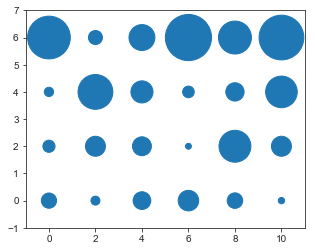

In [186]:
x = (0, 2, 4, 6, 8, 10) * 4
y = list()
for i in (6, 4, 2, 0):
    y.extend((i,) * 6)
    
levels = ['A','B','C','D']

proportion = np.zeros((4,6))
for i, level in enumerate(levels):
    for j, disease in enumerate(diseases):
        proportion[i][j] = disease_actionability_count[(disease, level)] / sample_disease_count[disease]
proportion[:,5] = (.5,.25,.1,.01)

f, ax = plt.subplots(figsize=(5, 4))
ax.set_xlim(-1,11)
ax.set_ylim(-1,7)
plt.scatter(x, y, s=proportion*4000)
# f.savefig(str(FIGPATH / 'misc_figures' / 'disease_actionability.pdf'), format='pdf')

In [187]:
diseases

['lung cancer',
 'breast cancer',
 'hematologic cancer',
 'large intestine cancer',
 'melanoma']

In [188]:
interpretable_disease_counts = np.zeros((4,2))
total_counts = np.zeros(2)
genie_topnode_diseases = set([
        x[0] for x in disease_actionability_count
    ])
for disease in genie_topnode_diseases:
    for i, level in enumerate(levels):
        if disease in diseases:
            j = 0
        else:
            j = 1
        interpretable_disease_counts[i][j]   += disease_actionability_count[(disease, level)]
    total_counts[j] += sample_disease_count[disease]


In [189]:
test_matrix = np.zeros((2,2))
test_matrix[0,:] = interpretable_disease_counts.sum(axis=0)
test_matrix[1,:] = total_counts - test_matrix[0,:]
print(test_matrix[0,:] / total_counts)
print(test_matrix)

stats.fisher_exact(test_matrix)

[0.55574491 0.39565724]
[[6196. 5430.]
 [4953. 8294.]]


(1.910765021775593, 3.937226666968854e-140)

In [190]:
interpretable_disease_counts.sum(axis=0)

array([6196., 5430.])

In [191]:
test_matrix = np.zeros((2,2))
test_matrix[0,:] = interpretable_disease_counts[:2,:].sum(axis=0)
test_matrix[1,:] = total_counts - test_matrix[0,:]
print(test_matrix[0,:] / total_counts)
print(test_matrix)

result = stats.fisher_exact(test_matrix)
print(result)

[0.43779711 0.177645  ]
[[ 4881.  2438.]
 [ 6268. 11286.]]
(3.60484142012268, 0.0)


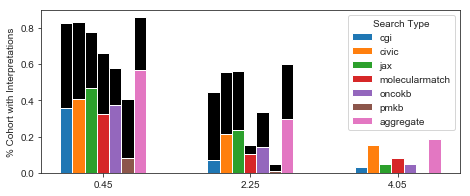

In [192]:
fig, ax = plt.subplots(figsize=(7.5,3))

counts = actionability_sum
groups = ['Variant', 'Variant + Disease', 'Variant + Disease + Tier I']
subs = SOURCES + ('aggregate',)
width = 0.15
plot_elements = list()
resource_ind = np.arange(3)

for i, source in enumerate(subs):
    x = np.array([actionability_sum[i + 24], actionability_sum[i + 32], 0]) / ALL_PATIENT_COUNT
    ind = np.array((i, i+12, i+24)) * width
    p = ax.bar(ind, x, width, label=source, color='black')
    plot_elements.append(p)

for i, source in enumerate(subs):
    x = np.array([actionability_sum[i], actionability_sum[i + 8], actionability_sum[i + 16]]) / ALL_PATIENT_COUNT
    ind = np.array((i, i+12, i+24)) * width
    p = ax.bar(ind, x, width, label=source)
    plot_elements.append(p)

ax.set_xticks(ind - 3*width)
# ax.set_xticklabels(groups, rotation='vertical')
handles, labels = ax.get_legend_handles_labels()
half_idx = len(labels) // 2
ax.legend(handles[half_idx:], labels[half_idx:], title='Search Type')
plt.ylabel('% Cohort with Interpretations')

plt.show()
# fig.savefig(str(FIGPATH / 'misc_figures' / 'genie_actionability.pdf'), format='pdf')

In [193]:
(actionability_sum / ALL_PATIENT_COUNT).reshape((5,8))

array([[0.35852069, 0.40539692, 0.46658989, 0.32433847, 0.37202607,
        0.0813987 , 0.56646688, 0.        ],
       [0.07090324, 0.21255267, 0.23807156, 0.10411705, 0.14154474,
        0.00806135, 0.29468422, 0.        ],
       [0.02936635, 0.15363677, 0.04815871, 0.07940953, 0.04831575,
        0.00701442, 0.18483524, 0.        ],
       [0.82610516, 0.83267464, 0.77493653, 0.66223467, 0.57599393,
        0.40780485, 0.85654461, 0.        ],
       [0.44693381, 0.55806528, 0.55937394, 0.15248515, 0.3360379 ,
        0.04868218, 0.59758683, 0.        ]])

In [194]:
# Average individual KB variant matching, exact searching
(actionability_sum[:6] / ALL_PATIENT_COUNT).mean()

0.33471178928817585

In [195]:
# Average individual KB variant+disease matching, exact searching
(actionability_sum[8:14] / ALL_PATIENT_COUNT).mean()

0.12920843475453886

In [196]:
# Average individual KB variant+disease+tier I matching, exact searching
(actionability_sum[16:22] / ALL_PATIENT_COUNT).mean()

0.06098358939461355

In [197]:
# Average individual KB variant matching, broad searching
(actionability_sum[24:30] / ALL_PATIENT_COUNT).mean()

0.6799582973451636

In [198]:
# Average individual KB variant+disease matching, broad searching
(actionability_sum[32:38] / ALL_PATIENT_COUNT).mean()

0.3502630408040411

In [199]:
c = defaultdict(Counter)
for a in core_vdb:
    c[a.source][a.evidence_level] += 1

In [200]:
c

defaultdict(collections.Counter,
            {'molecularmatch': Counter({'A': 782,
                      'B': 133,
                      'C': 196,
                      'D': 969}),
             'civic': Counter({'C': 1234, 'D': 918, 'B': 1130, 'A': 58}),
             'pmkb': Counter({'A': 261, 'D': 17, 'C': 93}),
             'oncokb': Counter({'D': 75, 'C': 65, 'B': 46, 'A': 61}),
             'jax': Counter({'D': 4518, 'C': 1041, 'B': 89, 'A': 98}),
             'cgi': Counter({'D': 415, 'C': 497, 'A': 120, 'B': 40})})

In [201]:
for source, counts in c.items():
    tier1 = (counts['A'] + counts['B']) / sum(counts.values())
    print("{}: Tier 1 is {:.1%} of total.".format(source, tier1))

molecularmatch: Tier 1 is 44.0% of total.
civic: Tier 1 is 35.6% of total.
pmkb: Tier 1 is 70.4% of total.
oncokb: Tier 1 is 43.3% of total.
jax: Tier 1 is 3.3% of total.
cgi: Tier 1 is 14.9% of total.


In [202]:
s = len(patients_with_topnode)
s / ALL_PATIENT_COUNT

0.6482058261575104

In [203]:
len(sample_oncotree_code)

39600

In [204]:
code_patient_count = Counter()
for patient, samples in patient_to_samples.items():
    patient_codes = set()
    for sample in samples:
        patient_codes.add(sample_oncotree_code[sample])
    for code in patient_codes:
        code_patient_count[code] += 1

In [205]:
patient_count = len(patient_to_samples)
for code, count in code_patient_count.most_common():
    f = count / patient_count
    print('{}: {:.1%}, {}'.format(code, f, count))

LUAD: 12.4%, 4738
IDC: 7.7%, 2947
COAD: 5.8%, 2218
PRAD: 3.5%, 1323
COADREAD: 3.2%, 1207
PAAD: 2.6%, 1005
SKCM: 2.2%, 845
BLCA: 2.0%, 773
GBM: 2.0%, 772
AML: 1.8%, 687
HGSOC: 1.8%, 681
READ: 1.7%, 650
MEL: 1.5%, 578
LUSC: 1.4%, 549
UEC: 1.3%, 509
CCRCC: 1.2%, 443
ILC: 1.2%, 441
CUP: 1.1%, 412
BRCA: 1.1%, 406
GIST: 1.0%, 386
GB: 1.0%, 378
THPA: 1.0%, 371
ESCA: 1.0%, 369
STAD: 0.8%, 314
MDS: 0.7%, 265
SOC: 0.7%, 262
OCSC: 0.7%, 254
NSCLC: 0.7%, 253
ADNOS: 0.6%, 239
MDLC: 0.6%, 232
LMS: 0.6%, 231
SCLC: 0.6%, 225
AASTR: 0.6%, 213
ASTR: 0.6%, 211
HCC: 0.5%, 205
CHOL: 0.5%, 203
USC: 0.5%, 201
ACYC: 0.5%, 192
HNSC: 0.5%, 191
IHCH: 0.5%, 185
PANET: 0.4%, 169
OPHSC: 0.4%, 163
MNG: 0.4%, 155
PLEMESO: 0.4%, 154
UTUC: 0.4%, 152
DLBCL: 0.4%, 152
GEJ: 0.4%, 150
ODG: 0.4%, 147
MACR: 0.4%, 146
RCC: 0.4%, 145
MCC: 0.4%, 143
UCS: 0.4%, 137
OTHER: 0.4%, 136
CLL: 0.3%, 133
NSCLCPD: 0.3%, 131
PTAD: 0.3%, 124
BRCANOS: 0.3%, 121
NBL: 0.3%, 121
CSCC: 0.3%, 120
ULMS: 0.3%, 113
SEM: 0.3%, 113
ES: 0.3%, 113
BMGC

In [206]:
cancer_rank = {pair[0]: rank for rank, pair in enumerate(
        code_patient_count.most_common()
    ) if pair[0] not in patched_doids} # Exclude manual patching for analysis

In [207]:
mapped = list()
unmapped = list()
for code, rank in cancer_rank.items():
    doids = oncotree_to_doids.get(code, False)
    if doids:
        mapped.append(rank)
    else:
        unmapped.append(rank)

In [208]:
print(mapped)
print(unmapped)
print(len(mapped) / (len(unmapped) + len(mapped)))
stats.mannwhitneyu(mapped, unmapped, alternative='two-sided')

[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 19, 20, 21, 22, 23, 25, 27, 30, 31, 32, 33, 35, 36, 38, 39, 42, 46, 49, 51, 57, 58, 59, 61, 62, 65, 68, 71, 72, 73, 75, 76, 77, 83, 85, 88, 89, 90, 91, 94, 95, 96, 97, 98, 100, 101, 102, 106, 109, 110, 112, 115, 121, 122, 124, 125, 126, 129, 131, 133, 137, 139, 140, 141, 142, 144, 145, 146, 154, 155, 157, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 175, 176, 178, 179, 184, 188, 189, 191, 192, 193, 195, 203, 204, 206, 207, 208, 210, 214, 215, 216, 218, 220, 221, 223, 225, 228, 229, 230, 235, 236, 237, 238, 239, 243, 244, 248, 249, 250, 253, 254, 258, 262, 264, 266, 272, 274, 277, 280, 282, 283, 284, 285, 295, 296, 298, 299, 301, 304, 305, 306, 307, 314, 316, 317, 320, 321, 324, 325, 327, 328, 330, 331, 334, 335, 336, 339, 340, 341, 342, 344, 345, 348, 349, 350, 356, 359, 362, 365, 370, 373, 374, 376, 383, 384, 385, 386, 390, 391, 392, 393, 394, 395, 397, 400, 402, 404, 408, 410, 413, 416, 419, 420, 424, 427, 430, 432, 433, 436, 441, 

MannwhitneyuResult(statistic=31094.0, pvalue=0.004836510453696477)

In [209]:
cancer_rank

{'LUAD': 0,
 'IDC': 1,
 'COAD': 2,
 'PRAD': 3,
 'COADREAD': 4,
 'PAAD': 5,
 'SKCM': 6,
 'BLCA': 7,
 'GBM': 8,
 'AML': 9,
 'HGSOC': 10,
 'READ': 11,
 'MEL': 12,
 'LUSC': 13,
 'UEC': 14,
 'CCRCC': 15,
 'ILC': 16,
 'CUP': 17,
 'BRCA': 18,
 'GIST': 19,
 'GB': 20,
 'THPA': 21,
 'ESCA': 22,
 'STAD': 23,
 'MDS': 24,
 'SOC': 25,
 'OCSC': 26,
 'NSCLC': 27,
 'ADNOS': 28,
 'MDLC': 29,
 'LMS': 30,
 'SCLC': 31,
 'AASTR': 32,
 'ASTR': 33,
 'HCC': 34,
 'CHOL': 35,
 'USC': 36,
 'HNSC': 38,
 'IHCH': 39,
 'PANET': 40,
 'OPHSC': 41,
 'MNG': 42,
 'PLEMESO': 43,
 'UTUC': 44,
 'DLBCL': 45,
 'GEJ': 46,
 'ODG': 47,
 'MACR': 48,
 'RCC': 49,
 'MCC': 50,
 'UCS': 51,
 'OTHER': 52,
 'CLL': 53,
 'NSCLCPD': 54,
 'PTAD': 55,
 'BRCANOS': 56,
 'NBL': 57,
 'CSCC': 58,
 'ULMS': 59,
 'ES': 61,
 'BMGCT': 62,
 'BALL': 63,
 'SARCNOS': 64,
 'MFH': 65,
 'BRCNOS': 66,
 'MUP': 67,
 'OS': 68,
 'NECNOS': 69,
 'CCOV': 70,
 'GBC': 71,
 'UCEC': 72,
 'APAD': 73,
 'MYF': 74,
 'PRCC': 75,
 'CESC': 76,
 'ANSC': 77,
 'DDLS': 78,
 'THPD': 

In [210]:
len(unmapped)

286

In [211]:
np.mean(mapped)

251.1185770750988

In [212]:
np.mean(unmapped)

289.2307692307692

## Interpretation gene intersection search

In [213]:
a = core_vdb[0]
f = genie_features[0]

In [214]:
e_level = defaultdict(dict)
gene_diseases = defaultdict(lambda: defaultdict(set))
for association in core_vdb:
    source = association.source
    for gene in association.genes:
        try:
            disease = association.disease.id
        except AttributeError:
            continue
        key = (gene.symbol, disease)
        gene_diseases[source][gene.symbol].add(disease)
        gene_diseases['aggregate'][gene.symbol].add(disease)
        current = e_level[source].get(key, None)
        new = association.evidence_level
        if current is None or new < current:
            e_level[source][key] = new
        current = e_level['aggregate'].get(key, None)
        if current is None or new < current:
            e_level['aggregate'][key] = new

In [215]:
patient_gene_actionability = dict()
for patient in featured_patients:
    samples = patient_to_samples[patient]
    actionable = np.zeros(24) # [0..5]: sources (exact), 6: combined, 7: deprecated. 
                              # +8 for +disease +16 for +dis/tier1
    aggregate_gene_diseases = gene_diseases['aggregate']
    aggregate_e_level = e_level['aggregate']
    for sample in samples:
        sample_disease = sample_to_doid[sample]
        features = genie_features_by_sample[sample]
        evidence_level = None
        for feature in features:
            feature_gene = feature.gene_symbol
            if feature_gene not in aggregate_gene_diseases:
                continue
            actionable[6] = 1
            for interpretation_disease in aggregate_gene_diseases[feature_gene]:
                if disease_dist(interpretation_disease, sample_disease) >= 0:
                    actionable[14] = 1
                    if aggregate_e_level[(feature_gene, interpretation_disease)] in ['A', 'B']:
                        actionable[22] = 1
                        break
            for i, source in enumerate(SOURCES):
                source_e_level = e_level[source]
                source_gene_diseases = gene_diseases[source]
                if feature_gene not in source_gene_diseases:
                    continue
                actionable[i] = 1
                if not actionable[14]:
                    continue
                for interpretation_disease in source_gene_diseases[feature_gene]:
                    if disease_dist(interpretation_disease, sample_disease) >= 0:
                        actionable[i + 8] = 1
                        if source_e_level[(feature_gene, interpretation_disease)] in ['A', 'B']:
                            actionable[i + 16] = 1
                            break
    patient_gene_actionability[patient] = actionable
    
gene_actionability_grid = np.array(list(patient_gene_actionability.values()))
gene_actionability_sum = gene_actionability_grid.sum(axis=0)

In [216]:
(gene_actionability_sum / ALL_PATIENT_COUNT).reshape((3,8))

array([[0.83992462, 0.84670348, 0.80835972, 0.76768655, 0.62310571,
        0.73622635, 0.861439  , 0.        ],
       [0.5642945 , 0.56811579, 0.58235402, 0.18305546, 0.35517052,
        0.10361976, 0.60716623, 0.        ],
       [0.13916298, 0.46920721, 0.2367629 , 0.12107729, 0.09500877,
        0.0678148 , 0.49705551, 0.        ]])

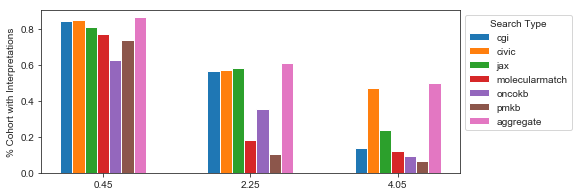

In [217]:
fig, ax = plt.subplots(figsize=(7.5,3))

counts = gene_actionability_sum
groups = ['Variant', 'Variant + Disease', 'Variant + Disease + Tier I']
subs = SOURCES + ('aggregate',)
width = 0.15
plot_elements = list()
resource_ind = np.arange(3)

# for i, source in enumerate(subs):
#     x = np.array([gene_actionability_sum[i + 24], gene_actionability_sum[i + 32], 0]) / gene_actionability_grid.shape[0]
#     ind = np.array((i, i+12, i+24)) * width
#     p = ax.bar(ind, x, width, label=source, color='black')
#     plot_elements.append(p)

for i, source in enumerate(subs):
    x = np.array([gene_actionability_sum[i], gene_actionability_sum[i + 8], gene_actionability_sum[i + 16]]) / ALL_PATIENT_COUNT
    ind = np.array((i, i+12, i+24)) * width
    p = ax.bar(ind, x, width, label=source)
    plot_elements.append(p)

ax.set_xticks(ind - 3*width)
# ax.set_xticklabels(groups, rotation='vertical')
handles, labels = ax.get_legend_handles_labels()
# half_idx = len(labels) // 2
half_idx = 0
lgd = ax.legend(handles[half_idx:], labels[half_idx:], title='Search Type',
          bbox_to_anchor=(1,1)
         )
plt.ylabel('% Cohort with Interpretations')

plt.show()
# fig.savefig(str(FIGPATH / 'misc_figures' / 'genie_gene_actionability.pdf'), format='pdf',
#             bbox_extra_artists=(lgd, ), bbox_inches='tight'
#            )

# Quantitative value of harmonization

## Genes

In [218]:
raw_genes = list()

### CGI

In [219]:
def create_raw_cgi_genes(vdb):
    cgi = vdb.by_source('cgi')
    genes = list()
    for interpretation in cgi:
        for gene in interpretation['raw']['Gene'].split(';'):
            genes.append(gene)
    return genes

In [220]:
cgi_genes = create_raw_cgi_genes(core_vdb)

In [221]:
raw_genes.extend(set(cgi_genes))

### CIViC

In [222]:
def create_raw_civic_genes(vdb):
    civic = vdb.by_source('civic')
    genes = list()
    for interpretation in civic:
        genes.append(interpretation['raw']['entrez_name'])
    return genes

In [223]:
civic_genes = create_raw_civic_genes(core_vdb)

In [224]:
raw_genes.extend(set(civic_genes))

### JAX-CKB

In [225]:
def create_raw_jax_genes(vdb):
    jax = vdb.by_source('jax')
    genes = list()
    for interpretation in jax:
        for gene in interpretation['genes']:
            genes.append(gene.strip())
    return genes

In [226]:
jax_genes = create_raw_jax_genes(core_vdb)

In [227]:
raw_genes.extend(set(jax_genes))

### MolecularMatch

In [228]:
def create_raw_molecularmatch_genes(vdb):
    mm = vdb.by_source('molecularmatch')
    genes = list()
    for interpretation in mm:
        genes2 = interpretation['raw'].get('includeGene0', None)
        if not genes2:
            genes2 = interpretation['raw'].get('includeGene1', None)
        if genes2:
            genes.extend(genes2)
    return genes

In [229]:
mm_genes = create_raw_molecularmatch_genes(core_vdb)

In [230]:
raw_genes.extend(set(mm_genes))

### OncoKB

In [231]:
def create_raw_okb_genes(vdb):
    okb = vdb.by_source('oncokb')
    genes = list()
    for interpretation in okb:
        gene = interpretation['raw']['clinical']['gene']
        genes.append(gene)
    return genes

In [232]:
okb_genes = create_raw_okb_genes(core_vdb)

In [233]:
raw_genes.extend(set(okb_genes))

### PMKB

In [234]:
def create_raw_pmkb_genes(vdb):
    pmkb = vdb.by_source('pmkb')
    genes = list()
    for interpretation in pmkb:
        gene = interpretation['raw']['variant']['gene']['name']
        genes.append(gene)
    return genes

In [235]:
pmkb_genes = create_raw_pmkb_genes(core_vdb)

In [236]:
raw_genes.extend(set(pmkb_genes))

### Harmonized genes

In [237]:
h_genes = list()

for source in core_vdb.sources:
    unique_source_genes = set()
    for interpretation in core_vdb.by_source(source):
        for gene in interpretation.genes:
            unique_source_genes.add(gene.symbol)
    print(f'{source}: {len(unique_source_genes)}')
    h_genes.extend(unique_source_genes)

molecularmatch: 109
civic: 296
pmkb: 42
oncokb: 44
jax: 107
cgi: 182


### Comparison

In [238]:
raw_start = len(raw_genes)
raw_uniq = len(set(raw_genes))
h_start = len(h_genes)
h_uniq = len(set(h_genes))

In [239]:
1 - (h_uniq / h_start)

0.46282051282051284

In [240]:
1 - (raw_uniq / raw_start)

0.44956413449564137

## Variants

In [241]:
raw_features = list()

### CGI

In [242]:
hgvs_re = re.compile(r'(.*):g.(\d+)(\w+)>(\w+)')

def hgvs_to_coords(hgvs):
    match = hgvs_re.match(hgvs)
    if not match:
        return None
    groups = match.groups()
    return (str(groups[0]), int(groups[1]), int(groups[1]) + len(groups[2]) - 1)

def create_raw_cgi_features(vdb):
    cgi = vdb.by_source('cgi')
    features = list()
    for interpretation in cgi:
        for f in interpretation['raw']['gDNA']:
            if not f:
                continue
            coords = hgvs_to_coords(f)
            if coords:
                features.append(coords)
    return features
            

In [243]:
cgi_features = create_raw_cgi_features(core_vdb)

In [244]:
len(set(cgi_features))

283

In [245]:
raw_features.extend(set(cgi_features))

### CIViC

In [246]:
def create_raw_civic_features(vdb):
    civic = vdb.by_source('civic')
    features = list()
    harmonized_features = list()
    for interpretation in civic:
        coordinates = interpretation['raw']['coordinates']
        gf = (
            coordinates['chromosome'],
            coordinates['start'],
            coordinates['stop'],
#             coordinates['variant_bases']
        )
        if not all(gf[:3]):
            continue
        features.append(gf)
    return features

In [247]:
civic_features = create_raw_civic_features(core_vdb)

In [248]:
len(set(civic_features))

710

In [249]:
raw_features.extend(set(civic_features))

### JAX-CKB

There is nothing to do for this resource. Without harmonization or inference routines, cannot ascribe variant names to coordinates.

### MolecularMatch

In [250]:
def create_raw_molecularmatch_features(vdb):
    features = list()
    mm = vdb.by_source('molecularmatch')
    for interpretation in mm:
        for mutation in interpretation['raw']['mutations']:
            try:
                coords = mutation['GRCh37_location'][0] # Take first coord only
            except IndexError:
                continue
            try:
                start = int(coords['start'])
                stop = int(coords['stop'])
            except TypeError:
                continue
            assert start <= stop
            chromosome = coords['chr']
            alt = coords['alt']
            if not all([chromosome, start, stop]):
                continue
            f = (chromosome, start, stop)
            features.append(f)
    return features
    

In [251]:
mm_features = create_raw_molecularmatch_features(core_vdb)

In [252]:
len(set(mm_features))

427

In [253]:
raw_features.extend(set(mm_features))

### OncoKB

All mutations at protein level.

### PMKB

In [254]:
def create_raw_pmkb_features(vdb):
    features = list()
    pmkb = vdb.by_source('pmkb')
    for interpretation in pmkb:
        coordinates = interpretation['raw']['variant']['coordinates']
        for coordinate in coordinates.split(', '):
            chromosome, r = coordinate.split(':')
            start, stop = r.split('-')
            features.append((chromosome, int(start), int(stop)))
    return features

In [255]:
pmkb_features = create_raw_pmkb_features(core_vdb)

In [256]:
len(set(pmkb_features))

161

In [257]:
raw_features.extend(set(pmkb_features))

### Harmonized features

In [258]:
h_features = list()

for source in core_vdb.sources:
    unique_source_features = set([x[0] for x in core_vdb.by_source(source).features])
    print(f'{source}: {len(unique_source_features)}')
    h_features.extend(unique_source_features)

molecularmatch: 676
civic: 850
pmkb: 164
oncokb: 652
jax: 725
cgi: 1600


In [259]:
len(h_features)

4667

### Comparison

In [260]:
raw_start = len(raw_features)
raw_uniq = len(set(raw_features))
h_start = len(h_features)
h_uniq = len(set(h_features))

In [261]:
1 - (h_uniq / h_start)

0.2635526033854725

In [262]:
1 - (raw_uniq / raw_start)

0.07969639468690703

## Diseases

In [263]:
raw_diseases = list()

### CGI

In [264]:
def create_raw_cgi_diseases(vdb):
    cgi = vdb.by_source('cgi')
    diseases = list()
    for interpretation in cgi:
        for d in interpretation['raw']['Primary Tumor type'].split(';'):
            diseases.append(d.lower())
    return diseases

In [265]:
cgi_diseases = create_raw_cgi_diseases(core_vdb)

In [266]:
raw_diseases.extend(set(cgi_diseases))

### CIViC

In [267]:
def create_raw_civic_diseases(vdb):
    civic = vdb.by_source('civic')
    diseases = list()
    for interpretation in civic:
        disease = interpretation['raw']['evidence_items'][0]['disease']['display_name']
        diseases.append(disease.lower())
    return diseases

In [268]:
civic_diseases = create_raw_civic_diseases(core_vdb)

In [269]:
raw_diseases.extend(set(civic_diseases))

### JAX-CKB

In [270]:
def create_raw_jax_diseases(vdb):
    jax = vdb.by_source('jax')
    diseases = list()
    for interpretation in jax:
        disease = interpretation['raw']['indication']['name']
        diseases.append(disease.lower())
    return diseases

In [271]:
jax_diseases = create_raw_jax_diseases(core_vdb)

In [272]:
raw_diseases.extend(set(jax_diseases))

### MolecularMatch

In [273]:
def create_raw_mm_diseases(vdb):
    mm = vdb.by_source('molecularmatch')
    diseases = list()
    for interpretation in mm:
        disease = interpretation['raw']['includeCondition1'][0]
        diseases.append(disease.lower())
    return diseases

In [274]:
mm_diseases = create_raw_mm_diseases(core_vdb)

In [275]:
raw_diseases.extend(set(mm_diseases))

### OncoKB

In [276]:
def create_raw_okb_diseases(vdb):
    okb = vdb.by_source('oncokb')
    diseases = list()
    for interpretation in okb:
        disease = interpretation['raw']['clinical']['cancerType']
        diseases.append(disease.lower())
    return diseases

In [277]:
okb_diseases = create_raw_okb_diseases(core_vdb)

In [278]:
raw_diseases.extend(set(okb_diseases))

### PMKB

In [279]:
def create_raw_pmkb_diseases(vdb):
    pmkb = vdb.by_source('pmkb')
    diseases = list()
    for interpretation in pmkb:
        for tissue in interpretation['raw']['tissues']:
            disease = ' '.join([tissue['name'], interpretation['raw']['tumor']['name']])
            diseases.append(disease.lower())
    return diseases

In [280]:
pmkb_diseases = create_raw_pmkb_diseases(core_vdb)

In [281]:
raw_diseases.extend(set(pmkb_diseases))

### Harmonized diseases

In [282]:
h_diseases = list()

for source in core_vdb.sources:
    unique_source_diseases = set([x.disease.term for x in core_vdb.by_source(source) if x.disease])
    print(f'{source}: {len(unique_source_diseases)}')
    h_diseases.extend(unique_source_diseases)

molecularmatch: 12
civic: 190
pmkb: 46
oncokb: 36
jax: 205
cgi: 123


In [283]:
len(h_diseases)

612

### Comparison

In [284]:
raw_start = len(raw_diseases)
raw_uniq = len(set(raw_diseases))
h_start = len(h_diseases)
h_uniq = len(set(h_diseases))

In [285]:
1 - (h_uniq / h_start)

0.3758169934640523

In [286]:
1 - (raw_uniq / raw_start)

0.2680722891566265

## Drugs

In [287]:
raw_drugs = list()

### CGI

In [288]:
def create_raw_cgi_drugs(vdb):
    cgi = vdb.by_source('cgi')
    drugs = list()
    for interpretation in cgi:
        for drug in interpretation['raw']['Drug full name'].split('+'):
            drugs.append(drug.strip().lower())
    return drugs

In [289]:
cgi_drugs = create_raw_cgi_drugs(core_vdb)

In [290]:
raw_drugs.extend(set(cgi_drugs))

### CIViC

In [291]:
def create_raw_civic_drugs(vdb):
    civic = vdb.by_source('civic')
    drugs = list()
    for interpretation in civic:
        for drug in interpretation['raw']['evidence_items'][0]['drugs']:
            drugs.append(drug['name'].lower())
    return drugs

In [292]:
civic_drugs = create_raw_civic_drugs(core_vdb)

In [293]:
raw_drugs.extend(set(civic_drugs))

### JAX-CKB

In [294]:
def create_raw_jax_drugs(vdb):
    jax = vdb.by_source('jax')
    drugs = list()
    for interpretation in jax:
        for drug in interpretation['raw']['therapy']['therapyName'].split('+'):
            drugs.append(drug.strip().lower())
    return drugs

In [295]:
jax_drugs = create_raw_jax_drugs(core_vdb)

In [296]:
raw_drugs.extend(set(jax_drugs))

### MolecularMatch

In [297]:
def create_raw_mm_drugs(vdb):
    mm = vdb.by_source('molecularmatch')
    drugs = list()
    for interpretation in mm:
        try:
            for drug in interpretation['raw']['includeDrug1']:
                for drug2 in drug.split('+'):
                    drugs.append(drug2.strip().lower())
        except KeyError:
            continue
    return drugs

In [298]:
mm_drugs = create_raw_mm_drugs(core_vdb)

In [299]:
raw_drugs.extend(set(mm_drugs))

### OncoKB

In [300]:
def create_raw_okb_drugs(vdb):
    okb = vdb.by_source('oncokb')
    drugs = list()
    for interpretation in okb:
        for drug in interpretation['raw']['clinical']['drug'].split(','):
            for drug2 in drug.strip().split('+'):
                drugs.append(drug2.strip().lower())
    return drugs

In [301]:
okb_drugs = create_raw_okb_drugs(core_vdb)

In [302]:
raw_drugs.extend(set(okb_drugs))

### PMKB

PMKB does not provide drug fields

### Harmonized drugs

In [303]:
h_drugs = list()

for source in core_vdb.sources:
    unique_source_drugs = set()
    for interpretation in core_vdb.by_source(source):
        for drug in interpretation.drugs:
            unique_source_drugs.add(drug.term)
    print(f'{source}: {len(unique_source_drugs)}')
    h_drugs.extend(unique_source_drugs)

molecularmatch: 110
civic: 313
pmkb: 0
oncokb: 77
jax: 542
cgi: 200


### Comparison

In [304]:
raw_start = len(raw_drugs)
raw_uniq = len(set(raw_drugs))
h_start = len(h_drugs)
h_uniq = len(set(h_drugs))

In [305]:
1 - (h_uniq / h_start)

0.3631239935587761

In [306]:
1 - (raw_uniq / raw_start)

0.2028100183262065

In [307]:
Counter([x['raw']['clinicalSignificance'] for x in core_vdb.by_source('molecularmatch')])

Counter({'resistant': 854,
         'sensitive': 1217,
         'unfavorable': 4,
         'no_response': 1,
         'favorable': 1,
         'unknown': 3})

In [308]:
Counter([x['raw']['clinicalSignificance'] for x in vdb.by_source('molecularmatch')])

Counter({'resistant': 854,
         'sensitive': 1222,
         'unfavorable': 4,
         'no_response': 1,
         'favorable': 1,
         'unknown': 3})

# Export for Somatic Reference Sample project

In [309]:
import csv
with open('out/srs_export.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow([
            'chromosome',
            'start',
            'stop',
            'ref',
            'alt',
            'feature_label',
            'evidence_level',
            'drugs',
            'disease_context',
            'disease_id',
            'interpretation_source',
            'pmids',
        ])
    for a in core_vdb:
        pmids = '|'.join([str(x.pmid) for x in a.publications if x.pmid])
        drugs = '|'.join([str(x) for x in a.drugs if x])
        if a.evidence_level not in ['A', 'B']:
            continue
        for drug in a.drugs:
            assert '|' not in str(drug)
        for feature in a.features:
            try:
                feature_name = feature.name
            except AttributeError:
                feature_name = ''
            try:
                disease_name = a.disease.name
            except AttributeError:
                disease_name = a['association']['phenotype'].get('description', '')
            try:
                disease_id = a.disease.id
            except AttributeError:
                continue
            out = [feature.chromosome, feature.start, feature.end, 
                   feature.ref, feature.alt, feature_name, 
                   a.evidence_level, drugs,
                   disease_name, disease_id, a.source, pmids]
            if not (feature.ref and feature.alt):
                continue
            writer.writerow(out)


# Troubleshooting

In [310]:
x = core_vdb[0]

In [311]:
f = x.features[0]

In [312]:
x.disease.id

'DOID:3910'

In [313]:
len(unfiltered_patients_with_variants)

33852

In [314]:
len(unfiltered_patients_with_variants) / len(patient_to_samples)

0.8860156515821708

In [315]:
brca.report_groups()

0 total associations
